
# Comparison of ensembling classifiers internally using sampling


Ensembling classifiers have shown to improve classification performance compare
to single learner. However, they will be affected by class imbalance. This
example shows the benefit of balancing the training set before to learn
learners. We are making the comparison with non-balanced ensemble methods, XGBoost Classifier and Deep Neural Network Model.

We make a comparison using the balanced accuracy and geometric mean which are
metrics widely used in the literature to evaluate models learned on imbalanced
set.


# A. Data Engineering

## A.1. Load libraries

In [ ]:
%matplotlib inline
import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

#from imblearn.datasets import fetch_datasets
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import RUSBoostClassifier
from xgboost import XGBClassifier

from imblearn.metrics import geometric_mean_score

from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

import joblib # to save sklearn model

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in /usr/local/lib/python3.6/dist-packages (0.7.0)


## A.2. Load an imbalanced dataset

In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation. The target columns signifies whether or not a claim was filed for that policy holder.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Final Project/Banking Dataset/train.csv')
df_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Final Project/Banking Dataset/test.csv')

## A.3. Data Exploration

In [ ]:
subscribed_count = df_train.subscribed.value_counts()
subscribed_count 

no     27932
yes     3715
Name: subscribed, dtype: int64

The data set is imbalanced.
Class 0 (NOT SUBSCRIBED): 27932
Class 1 (SUBSCRIBED): 3715
Proportion of NOT SUBSCRIBED / SUBSCRIBED: 7.52 : 1


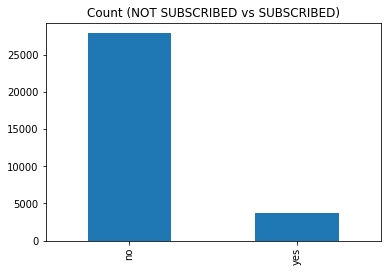

In [ ]:
subscribed_count = df_train.subscribed.value_counts()
print('The data set is imbalanced.')
print('Class 0 (NOT SUBSCRIBED):', subscribed_count[0])
print('Class 1 (SUBSCRIBED):', subscribed_count[1])
print('Proportion of NOT SUBSCRIBED / SUBSCRIBED:', round(subscribed_count[0] / subscribed_count[1], 2), ': 1')
subscribed_count.plot(kind='bar', title='Count (NOT SUBSCRIBED vs SUBSCRIBED)');

In [ ]:
df_train.shape

(31647, 18)

In [ ]:
df_test.shape

(13564, 17)

In [ ]:
df_train.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,26110,56,admin.,married,unknown,no,1933,no,no,telephone,19,nov,44,2,-1,0,unknown,no
1,40576,31,unknown,married,secondary,no,3,no,no,cellular,20,jul,91,2,-1,0,unknown,no
2,15320,27,services,married,secondary,no,891,yes,no,cellular,18,jul,240,1,-1,0,unknown,no
3,43962,57,management,divorced,tertiary,no,3287,no,no,cellular,22,jun,867,1,84,3,success,yes
4,29842,31,technician,married,secondary,no,119,yes,no,cellular,4,feb,380,1,-1,0,unknown,no


In [ ]:
df_test.head(5)

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,38441,32,services,married,secondary,no,118,yes,no,cellular,15,may,20,6,-1,0,unknown
1,40403,78,retired,divorced,primary,no,2787,no,no,telephone,1,jul,372,1,-1,0,unknown
2,3709,31,self-employed,single,tertiary,no,144,yes,no,unknown,16,may,676,1,-1,0,unknown
3,37422,57,services,single,primary,no,3777,yes,no,telephone,13,may,65,2,-1,0,unknown
4,12527,45,blue-collar,divorced,secondary,no,-705,no,yes,unknown,3,jul,111,1,-1,0,unknown


In [ ]:
df_train = df_train.set_index('ID')
df_test = df_test.set_index('ID')

In [ ]:
df_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
ID,,,,,,,,,,,,,,,,,
26110,56,admin.,married,unknown,no,1933,no,no,telephone,19,nov,44,2,-1,0,unknown,0
40576,31,unknown,married,secondary,no,3,no,no,cellular,20,jul,91,2,-1,0,unknown,0
15320,27,services,married,secondary,no,891,yes,no,cellular,18,jul,240,1,-1,0,unknown,0
43962,57,management,divorced,tertiary,no,3287,no,no,cellular,22,jun,867,1,84,3,success,1
29842,31,technician,married,secondary,no,119,yes,no,cellular,4,feb,380,1,-1,0,unknown,0


In [ ]:
df_test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
ID,,,,,,,,,,,,,,,,
38441,32,services,married,secondary,no,118,yes,no,cellular,15,may,20,6,-1,0,unknown
40403,78,retired,divorced,primary,no,2787,no,no,telephone,1,jul,372,1,-1,0,unknown
3709,31,self-employed,single,tertiary,no,144,yes,no,unknown,16,may,676,1,-1,0,unknown
37422,57,services,single,primary,no,3777,yes,no,telephone,13,may,65,2,-1,0,unknown
12527,45,blue-collar,divorced,secondary,no,-705,no,yes,unknown,3,jul,111,1,-1,0,unknown


## A.4. Check Missing or Nan




In [ ]:
df_train.isnull()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
ID,,,,,,,,,,,,,,,,,
26110,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
40576,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
15320,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
43962,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
29842,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36483,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
40178,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
19710,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
df_train.isna()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
ID,,,,,,,,,,,,,,,,,
26110,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
40576,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
15320,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
43962,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
29842,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36483,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
40178,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
19710,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
df_train.isnull().values.any()

False

In [ ]:
df_train.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance       0
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
subscribed    0
dtype: int64

In [ ]:
df_train.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance       0
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
subscribed    0
dtype: int64

In [ ]:
df_train.describe

<bound method NDFrame.describe of        age         job   marital  ... previous poutcome  subscribed
ID                                ...                              
26110   56      admin.   married  ...        0  unknown          no
40576   31     unknown   married  ...        0  unknown          no
15320   27    services   married  ...        0  unknown          no
43962   57  management  divorced  ...        3  success         yes
29842   31  technician   married  ...        0  unknown          no
...    ...         ...       ...  ...      ...      ...         ...
36483   29  management    single  ...        0  unknown          no
40178   53  management  divorced  ...        0  unknown         yes
19710   32  management    single  ...        0  unknown          no
38556   57  technician   married  ...       12  failure          no
14156   55  management  divorced  ...        0  unknown         yes

[31647 rows x 17 columns]>

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31647 entries, 26110 to 14156
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   age         31647 non-null  int64 
 1   job         31647 non-null  object
 2   marital     31647 non-null  object
 3   education   31647 non-null  object
 4   default     31647 non-null  object
 5   balance     31647 non-null  int64 
 6   housing     31647 non-null  object
 7   loan        31647 non-null  object
 8   contact     31647 non-null  object
 9   day         31647 non-null  int64 
 10  month       31647 non-null  object
 11  duration    31647 non-null  int64 
 12  campaign    31647 non-null  int64 
 13  pdays       31647 non-null  int64 
 14  previous    31647 non-null  int64 
 15  poutcome    31647 non-null  object
 16  subscribed  31647 non-null  object
dtypes: int64(7), object(10)
memory usage: 4.3+ MB


In [ ]:
df_train['subscribed'] = df_train['subscribed'].map({'yes': 1, 'no': 0})
df_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
ID,,,,,,,,,,,,,,,,,
26110,56,admin.,married,unknown,no,1933,no,no,telephone,19,nov,44,2,-1,0,unknown,0
40576,31,unknown,married,secondary,no,3,no,no,cellular,20,jul,91,2,-1,0,unknown,0
15320,27,services,married,secondary,no,891,yes,no,cellular,18,jul,240,1,-1,0,unknown,0
43962,57,management,divorced,tertiary,no,3287,no,no,cellular,22,jun,867,1,84,3,success,1
29842,31,technician,married,secondary,no,119,yes,no,cellular,4,feb,380,1,-1,0,unknown,0


## A.5. Create X, y

In [ ]:
y = df_train.subscribed
df_train_full = df_train.drop(columns=['subscribed'])  # labels = df_train.columns[:-1] ---> # X = df_train[labels]
print(df_train_full.shape)
df_train_full.head()

(31647, 16)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
ID,,,,,,,,,,,,,,,,
26110,56,admin.,married,unknown,no,1933,no,no,telephone,19,nov,44,2,-1,0,unknown
40576,31,unknown,married,secondary,no,3,no,no,cellular,20,jul,91,2,-1,0,unknown
15320,27,services,married,secondary,no,891,yes,no,cellular,18,jul,240,1,-1,0,unknown
43962,57,management,divorced,tertiary,no,3287,no,no,cellular,22,jun,867,1,84,3,success
29842,31,technician,married,secondary,no,119,yes,no,cellular,4,feb,380,1,-1,0,unknown


In [ ]:
y.head()

ID
26110    0
40576    0
15320    0
43962    1
29842    0
Name: subscribed, dtype: int64

In [ ]:
df_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31647 entries, 26110 to 14156
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        31647 non-null  int64 
 1   job        31647 non-null  object
 2   marital    31647 non-null  object
 3   education  31647 non-null  object
 4   default    31647 non-null  object
 5   balance    31647 non-null  int64 
 6   housing    31647 non-null  object
 7   loan       31647 non-null  object
 8   contact    31647 non-null  object
 9   day        31647 non-null  int64 
 10  month      31647 non-null  object
 11  duration   31647 non-null  int64 
 12  campaign   31647 non-null  int64 
 13  pdays      31647 non-null  int64 
 14  previous   31647 non-null  int64 
 15  poutcome   31647 non-null  object
dtypes: int64(7), object(9)
memory usage: 4.1+ MB


In [ ]:
g = df_train_full.columns.to_series().groupby(df_train_full.dtypes).groups
print(g)
dct = {k.name: v for k, v in g.items()}
print(dct)
# {'object': ['C', 'D'], 'int64': ['A', 'E'], 'float64': ['B']}
print(dct.get('object'))
print(dct.get('int64'))

{dtype('int64'): Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object'), dtype('O'): Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object')}
{'int64': Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object'), 'object': Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object')}
Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object')
Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')


In [ ]:
cat_cols = [x for x in df_test.columns if (df_test[x].dtypes=='object')]
num_cols = [x for x in df_test.columns if (df_test[x].dtypes!='object')]
print('Categorical columns: ', cat_cols)
print('Numerical columns: ', num_cols)

Categorical columns:  ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
Numerical columns:  ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [ ]:
categorical_cols = [x for x in df_train_full.columns if (df_train_full[x].dtypes=='object')]
numerical_cols = [x for x in df_train_full.columns if (df_train_full[x].dtypes!='object')]
print('Categorical columns: ', categorical_cols)
print('Numerical columns: ', numerical_cols)

Categorical columns:  ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
Numerical columns:  ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [ ]:
df_train_full[numerical_cols].corr()

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.103245,-0.011056,-0.003870,0.005733,-0.021947,0.005761
balance,0.103245,1.000000,0.003461,0.024274,-0.012032,0.001789,0.013843
day,-0.011056,0.003461,1.000000,-0.032288,0.159168,-0.087626,-0.048752
duration,-0.003870,0.024274,-0.032288,1.000000,-0.080305,0.000529,0.001783
campaign,0.005733,-0.012032,0.159168,-0.080305,1.000000,-0.087570,-0.033151
pdays,-0.021947,0.001789,-0.087626,0.000529,-0.087570,1.000000,0.428938
previous,0.005761,0.013843,-0.048752,0.001783,-0.033151,0.428938,1.000000


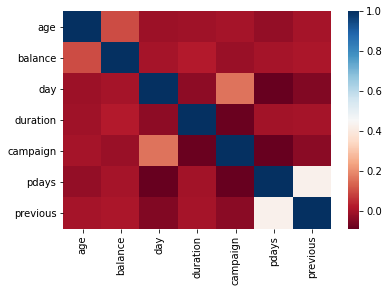

In [ ]:
sns.heatmap(df_train_full[numerical_cols].corr(),cmap="RdBu")

In [ ]:
df_train_full.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
ID,,,,,,,,,,,,,,,,
26110,56,admin.,married,unknown,no,1933,no,no,telephone,19,nov,44,2,-1,0,unknown
40576,31,unknown,married,secondary,no,3,no,no,cellular,20,jul,91,2,-1,0,unknown
15320,27,services,married,secondary,no,891,yes,no,cellular,18,jul,240,1,-1,0,unknown
43962,57,management,divorced,tertiary,no,3287,no,no,cellular,22,jun,867,1,84,3,success
29842,31,technician,married,secondary,no,119,yes,no,cellular,4,feb,380,1,-1,0,unknown


## A.6. One hot encoding

In [ ]:
df_train_full_merge = pd.concat([df_train_full[numerical_cols], pd.get_dummies(data=df_train_full[categorical_cols])], axis=1) # Train
df_test_merge = pd.concat([df_test[numerical_cols], pd.get_dummies(data=df_test[categorical_cols])], axis=1) # Test
print(df_train_full_merge.shape)
df_train_full_merge.head(5)

(31647, 51)


,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
26110,56,1933,19,44,2,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
40576,31,3,20,91,2,-1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
15320,27,891,18,240,1,-1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
43962,57,3287,22,867,1,84,3,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
29842,31,119,4,380,1,-1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1




## A.7. Split data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df_train_full_merge, y, test_size=0.4,shuffle=True,random_state=1612)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, shuffle=True, random_state=1612)
print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of y_val:', y_val.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train: (18988, 51)
Shape of y_train: (18988,)
Shape of X_val: (6330, 51)
Shape of y_val: (6330,)
Shape of X_test: (6329, 51)
Shape of y_test: (6329,)


In [ ]:
X_train.head()

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
28919,48,2091,2,94,1,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
11262,38,11,18,78,3,-1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
31304,28,171,10,93,1,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
203,44,575,5,477,1,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
38535,51,129,15,611,2,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [ ]:
y_train.head()

ID
28919    0
11262    0
31304    1
203      0
38535    1
Name: subscribed, dtype: int64

In [ ]:
X_val.head(5)

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10930,58,671,17,16,3,-1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
22196,52,17,21,97,4,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7323,37,1731,29,148,4,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
26215,49,852,20,408,1,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
13494,41,-426,9,294,1,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [ ]:
y_val.head()

ID
10930    0
22196    0
7323     0
26215    0
13494    0
Name: subscribed, dtype: int64

In [ ]:
X_test.head()

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4279,47,146,19,53,5,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
21744,51,370,19,109,3,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9716,36,115,6,201,1,-1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
20849,52,9139,13,684,2,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
22055,33,20794,20,226,5,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
y_test.head()

ID
4279     0
21744    0
9716     0
20849    0
22055    0
Name: subscribed, dtype: int64

## A.8. Unique values of each features

In [ ]:
print('age unique values: ', df_train['age'].unique())
print('job unique values: ', df_train['job'].unique())
print('marital unique values: ', df_train['marital'].unique())
print('education unique values: ', df_train['education'].unique())
print('default unique values: ', df_train['default'].unique())
print('balance unique values: ', df_train['balance'].unique())
print('housing unique values: ', df_train['housing'].unique())
print('loan unique values: ', df_train['loan'].unique())
print('contact unique values: ', df_train['contact'].unique())
print('day unique values: ', df_train['day'].unique())
print('month unique values: ', df_train['month'].unique())
print('duration unique values: ', df_train['duration'].unique())
print('campaign unique values: ', df_train['campaign'].unique())
# print('pdays unique values: ', df_train['pdays'].unique())
print('previous unique values: ', df_train['previous'].unique())
print('poutcome unique values: ', df_train['poutcome'].unique())

age unique values:  [56 31 27 57 33 50 45 35 36 44 39 43 41 53 64 48 60 29 30 42 46 32 63 47
 49 52 68 26 58 38 54 40 59 24 37 34 61 55 20 69 25 62 22 51 28 70 66 23
 87 71 74 81 73 76 72 84 19 79 75 21 83 80 67 18 77 65 82 86 78 88 92 95
 93 89 94 90]
job unique values:  ['admin.' 'unknown' 'services' 'management' 'technician' 'retired'
 'blue-collar' 'housemaid' 'self-employed' 'student' 'entrepreneur'
 'unemployed']
marital unique values:  ['married' 'divorced' 'single']
education unique values:  ['unknown' 'secondary' 'tertiary' 'primary']
default unique values:  ['no' 'yes']
balance unique values:  [1933    3  891 ... 2787 8741 2968]
housing unique values:  ['no' 'yes']
loan unique values:  ['no' 'yes']
contact unique values:  ['telephone' 'cellular' 'unknown']
day unique values:  [19 20 18 22  4  2  3  8 15  5 28  6 14  7 24 13  9 11 21 12 30 27 17 16
 25 10  1 29 26 31 23]
month unique values:  ['nov' 'jul' 'jun' 'feb' 'sep' 'jan' 'may' 'aug' 'apr' 'oct' 'mar' 'dec']
duration un

## A.9. Draw Pairplot

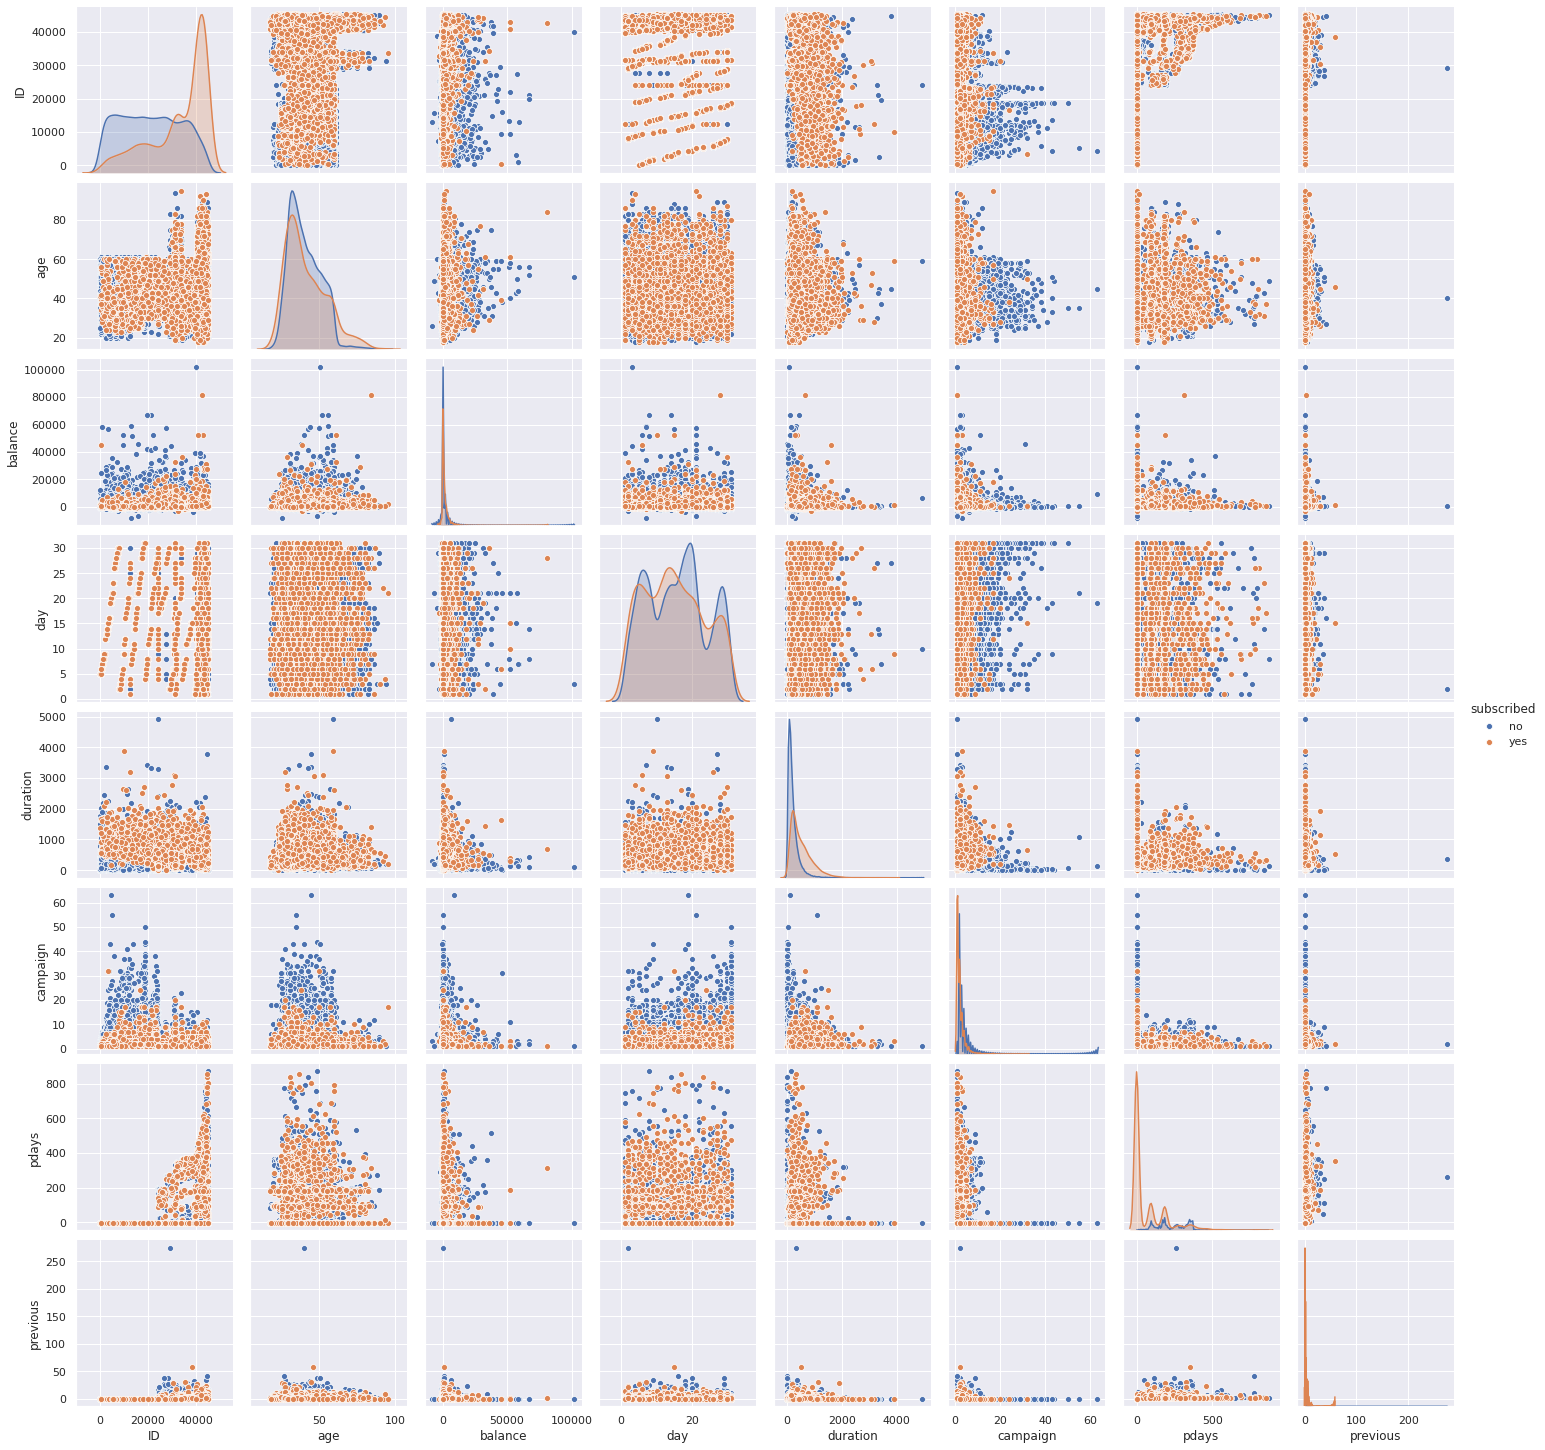

In [ ]:
# Other Data Preparation & Exploration: https://www.kaggle.com/bertcarremans/data-preparation-exploration
import seaborn as sns
sns.set()
sns.pairplot(df_train, hue='subscribed')

## A.10. Confusion Matrix Function

In [ ]:
def plot_confusion_matrix(cm, classes, ax,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(cm)
    print('')
    
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes, rotation=45)
    plt.sca(ax)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

# B. Ensemble Classifiers, XGBoost Classifier, Deep Neural Network

## B.1. Single Decision Tree



We use the training of Single Decision Tree classifier as a baseline to compare with other classifiers on this imbalanced dataset.

Balanced accuracy and geometric mean are reported followingly as they are metrics widely used in the literature to validate model trained on imbalanced set.

### B.1.1 Confusion Matrix

In [ ]:
# params = {
#     'criterion': ['entropy','gini'],
#     'max_leaf_nodes': list(range(2, 30)),
#     'max_depth': list(range(2, 10)),
#     'min_samples_split': np.linspace(0.1, 1.0, 10), 
#     'max_features': [1,2],
# }

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
# https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets  
params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}

decision_tree = DecisionTreeClassifier(random_state=1612)
decision_tree.fit(X_train, y_train)

rs_decision_tree = RandomizedSearchCV(decision_tree, params, cv=5)
rs_decision_tree.fit(X_train, y_train)
best_decision_tree = rs_decision_tree.fit(X_train, y_train)
rs_decision_tree.best_params_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  'searches, use GridSearchCV.'
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  'searches, use GridSearchCV.'


{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5}

Decision Tree classifier performance:
Balanced accuracy: 0.62 - Geometric mean 0.50
[[5463   86]
 [ 584  196]]



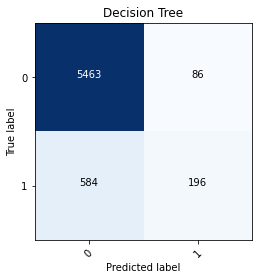

In [ ]:
y_pred_best_decision_tree = rs_decision_tree.predict(X_test)
print('Decision Tree classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_best_decision_tree),
              geometric_mean_score(y_test, y_pred_best_decision_tree)))
cm_decision_tree = confusion_matrix(y_test, y_pred_best_decision_tree)
fig, ax = plt.subplots()
plot_confusion_matrix(cm_decision_tree, classes=np.unique(y), ax=ax,
                      title='Decision Tree')

### B.1.2 Mean ROC AUC

In [ ]:
# Single decision tree
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1612)
# evaluate model
train_scores_decision_tree = cross_val_score(best_decision_tree, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
test_scores_decision_tree = cross_val_score(best_decision_tree, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)

# summarize performance
print('Mean ROC AUC on Train Set: %.3f' % mean(train_scores_decision_tree))
print('Mean ROC AUC on Test Set: %.3f' % mean(test_scores_decision_tree))

Mean ROC AUC on Train Set: 0.802
Mean ROC AUC on Test Set: 0.761


### B.1.3 Accuracy scores on Train / Test Set

In [ ]:
best_decision_tree = rs_decision_tree.best_estimator_
print('Accuracy on Train Set', best_decision_tree.score(X_train, y_train))
print('Accuracy on Test Set', best_decision_tree.score(X_test, y_test))

Accuracy on Train Set 0.9030440278070361
Accuracy on Test Set 0.8941380944857007


### B.1.4 Classification report

In [ ]:
y_pred_best_decision_tree_train = best_decision_tree.predict(X_train)
print('Accuracy score on Train Set of Best Decision Tree: {0:0.5f}'. format(accuracy_score(y_train, y_pred_best_decision_tree_train)))
print('Accuracy score on Test Set of Best Decision Tree: {0:0.5f}'. format(accuracy_score(y_test, y_pred_best_decision_tree)))
decision_tree_precision_train = precision_score(y_train, y_pred_best_decision_tree_train)
print('Precision score on Train Set of Best decision_tree: %f' % decision_tree_precision_train)
decision_tree_precision = precision_score(y_test, y_pred_best_decision_tree)
print('Precision score on Test Set of Best decision_tree: %f' % decision_tree_precision)
decision_tree_recall_train = recall_score(y_train, y_pred_best_decision_tree_train)
print('Recall score on Train Set of Best Decision Tree: %f' % decision_tree_recall_train)
decision_tree_recall = recall_score(y_test, y_pred_best_decision_tree)
print('Recall score on Test Set of Best Decision Tree: %f' % decision_tree_recall)
decision_tree_f1_train = f1_score(y_train, y_pred_best_decision_tree_train)
print('F1-score on Train Set of Best Decision Tree: %f' % decision_tree_f1_train)
decision_tree_f1 = f1_score(y_test, y_pred_best_decision_tree)
print('F1-score on Test Set of Best Decision Tree: %f' % decision_tree_f1)
print('\n')
print('Classification report on Train Set of Best Decision Tree: ', '\n', classification_report(y_train, y_pred_best_decision_tree_train))
print('\n')
print('Classification report on Test Set of Best Decision Tree: ', '\n', classification_report(y_test, y_pred_best_decision_tree))

Accuracy score on Train Set of Best Decision Tree: 0.90304
Accuracy score on Test Set of Best Decision Tree: 0.89414
Precision score on Train Set of Best decision_tree: 0.710493
Precision score on Test Set of Best decision_tree: 0.695035
Recall score on Train Set of Best Decision Tree: 0.258510
Recall score on Test Set of Best Decision Tree: 0.251282
F1-score on Train Set of Best Decision Tree: 0.379089
F1-score on Test Set of Best Decision Tree: 0.369115


Classification report on Train Set of Best Decision Tree:  
               precision    recall  f1-score   support

           0       0.91      0.99      0.95     16814
           1       0.71      0.26      0.38      2174

    accuracy                           0.90     18988
   macro avg       0.81      0.62      0.66     18988
weighted avg       0.89      0.90      0.88     18988



Classification report on Test Set of Best Decision Tree:  
               precision    recall  f1-score   support

           0       0.90      0.98

In [ ]:
# import joblib
model_decision_tree = '/content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Final Project/Banking Dataset/model_decision_tree.sav'
joblib.dump(best_decision_tree, model_decision_tree)

['/content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Final Project/Banking Dataset/model_decision_tree.sav']

## B.2. Bagging classifier with and without sampling




  A number of estimators are built on various randomly selected data subsets in ensemble classifiers. But each data subset is not allowed to be balanced by Bagging classifier because the majority classes will be favored by it when implementing training on imbalanced data set.

  In contrast, each data subset is allowed to be resample in ordor to have each ensemble's estimator trained by the Balanced Bagging Classifier. This means the output of an Easy Ensemble sample with an ensemble of classifiers, Bagging Classifier for instance will be combined. So an advantage of Balanced Bagging Classifier over Bagging Classifier from scikit learn is that it takes the same parameters and also another two parameters, sampling stratgy and replacement to keep the random under-sampler's behavior under control.

### B.2.1 Confusion Matrix

In [ ]:
# n_estimators = [10, 20]
# https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

In [ ]:
params = {
    'n_estimators': [5, 10],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
    'oob_score': [True, False],
    'warm_start': [True, False],
    'verbose': [0, 1],
    'max_features': [1,2],
}
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

In [ ]:
# rs_bagging = dict(params) # no need
bagging = BaggingClassifier(random_state=1612)
rs_bagging = RandomizedSearchCV(bagging, params, n_jobs=-1, cv=5, scoring='accuracy',error_score=0)
best_bagging = rs_bagging.fit(X_train, y_train)

# rs_balanced_bagging = dict(params) # no need
balanced_bagging = BalancedBaggingClassifier(random_state=1612)
rs_balanced_bagging = RandomizedSearchCV(balanced_bagging, params, n_jobs=-1, cv=5, scoring='accuracy', error_score=0)
best_balanced_bagging = rs_balanced_bagging.fit(X_train, y_train)

print('Best params of Bagging: ', best_bagging.best_params_)
print('Best params of Balanced Bagging: ', best_balanced_bagging.best_params_)

y_pred_best_bagging = best_bagging.predict(X_test)
y_pred_best_balanced_bagging = best_balanced_bagging.predict(X_test)
print(y_pred_best_bagging)
print(y_pred_best_balanced_bagging)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/

Best params of Bagging:  {'warm_start': True, 'verbose': 1, 'oob_score': False, 'n_estimators': 5, 'max_features': 1, 'bootstrap_features': False, 'bootstrap': True}
Best params of Balanced Bagging:  {'warm_start': False, 'verbose': 1, 'oob_score': True, 'n_estimators': 10, 'max_features': 2, 'bootstrap_features': False, 'bootstrap': True}
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  if mask[i]:
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Using 

Bagging classifier performance:
Balanced accuracy: 0.50 - Geometric mean 0.00
[[5549    0]
 [ 780    0]]

Balanced Bagging classifier performance:
Balanced accuracy: 0.73 - Geometric mean 0.73
[[4421 1128]
 [ 258  522]]



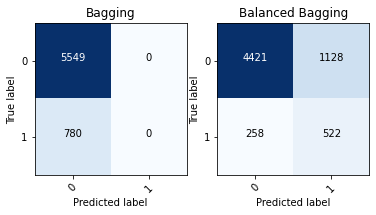

In [ ]:
# Balancing each bootstrap sample allows to increase significantly the balanced accuracy and the geometric mean.
print('Bagging classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_best_bagging),
              geometric_mean_score(y_test, y_pred_best_bagging)))
cm_best_bagging = confusion_matrix(y_test, y_pred_best_bagging)
fig, ax = plt.subplots(ncols=2)
plot_confusion_matrix(cm_best_bagging, classes=np.unique(y), ax=ax[0],
                      title='Bagging')

print('Balanced Bagging classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_best_balanced_bagging),
              geometric_mean_score(y_test, y_pred_best_balanced_bagging)))
cm_best_balanced_bagging = confusion_matrix(y_test, y_pred_best_balanced_bagging)
plot_confusion_matrix(cm_best_balanced_bagging, classes=np.unique(y),
                      ax=ax[1], title='Balanced Bagging')

### B.2.2 Mean ROC AUC 

In [ ]:
# Best Bagging classifier
# Define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1612)

# Evaluate model
train_scores_best_bagging = cross_val_score(best_bagging, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
test_scores_best_bagging = cross_val_score(best_bagging, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)

# Summarize performance
print('Mean ROC AUC on Train Set: %.3f' % mean(train_scores_best_bagging))
print('Mean ROC AUC on Test Set: %.3f' % mean(test_scores_best_bagging))

Mean ROC AUC on Train Set: 0.714
Mean ROC AUC on Test Set: 0.699


In [ ]:
# Best Balanced Bagging classifier 
# Define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1612)

# Evaluate model
train_scores_best_balanced_bagging = cross_val_score(best_balanced_bagging, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
test_scores_best_balanced_bagging = cross_val_score(best_balanced_bagging, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)

# Summarize performance
print('Mean ROC AUC on Train Set: %.3f' % mean(train_scores_best_balanced_bagging))
print('Mean ROC AUC on Test Set: %.3f' % mean(test_scores_best_balanced_bagging))

Mean ROC AUC on Train Set: 0.784
Mean ROC AUC on Test Set: 0.774


### B.2.3 Accuracy scores on Train / Test Set

In [ ]:
# Best Bagging & Balanced Bagging Classifiers
print('Bagging Classifier score on Train Set: ' + str(best_bagging.score(X_train, y_train)))
print('Balanced Bagging Classifier score on Test Set: ' + str(best_balanced_bagging.score(X_test, y_test)))

Bagging Classifier score on Train Set: 0.9977880766800085
Balanced Bagging Classifier score on Test Set: 0.8604834887027967


### B.2.4 Classification report

In [ ]:
y_pred_best_bagging_train = best_bagging.predict(X_train)
print('Accuracy score on Train Set of Best Bagging: {0:0.5f}'. format(accuracy_score(y_train, y_pred_best_bagging_train)))
print('Accuracy score on Test Set of Best Bagging: {0:0.5f}'. format(accuracy_score(y_test, y_pred_best_bagging)))
bagging_precision_train = precision_score(y_train, y_pred_best_bagging_train)
print('Precision score on Train Set of Best Bagging: %f' % bagging_precision_train)
bagging_precision = precision_score(y_test, y_pred_best_bagging)
print('Precision score on Test Set of Best Bagging: %f' % bagging_precision)
bagging_recall_train = recall_score(y_train, y_pred_best_bagging_train)
print('Recall score on Train Set of Best Bagging: %f' % bagging_recall_train)
bagging_recall = recall_score(y_test, y_pred_best_bagging)
print('Recall on Test Set of Best Bagging: %f' % bagging_recall)
bagging_f1 = f1_score(y_test, y_pred_best_bagging)
print('F1-score on Test Set of Best Bagging: %f' % bagging_f1)
print('\n')
print('Classification report on Train Set of Best Bagging: ', '\n', classification_report(y_train, y_pred_best_bagging_train))
print('Classification report on Test Set of Best Bagging: ', '\n', classification_report(y_test, y_pred_best_bagging))

Accuracy score on Train Set of Best Bagging: 0.88551
Accuracy score on Test Set of Best Bagging: 0.87676
Precision score on Train Set of Best Bagging: 0.000000
Precision score on Test Set of Best Bagging: 0.000000
Recall score on Train Set of Best Bagging: 0.000000
Recall on Test Set of Best Bagging: 0.000000
F1-score on Test Set of Best Bagging: 0.000000


Classification report on Train Set of Best Bagging:  
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     16814
           1       0.00      0.00      0.00      2174

    accuracy                           0.89     18988
   macro avg       0.44      0.50      0.47     18988
weighted avg       0.78      0.89      0.83     18988

Classification report on Test Set of Best Bagging:  
               precision    recall  f1-score   support

           0       0.88      1.00      0.93      5549
           1       0.00      0.00      0.00       780

    accuracy                           0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_pred_best_balanced_bagging_train = best_bagging.predict(X_train)
print('Accuracy score on Train Set of Best Balanced Bagging: {0:0.5f}'. format(accuracy_score(y_train, y_pred_best_balanced_bagging_train)))
print('Accuracy score on Test Set of Best Balanced Bagging: {0:0.5f}'. format(accuracy_score(y_test, y_pred_best_balanced_bagging)))
balanced_bagging_precision_train = precision_score(y_train, y_pred_best_balanced_bagging_train)
print('Precision score on Train Set of Best Balanced Bagging: %f' % balanced_bagging_precision_train)
balanced_bagging_precision = precision_score(y_test, y_pred_best_balanced_bagging)
print('Precision score on Test Set of Best Balanced Bagging: %f' % balanced_bagging_precision)
balanced_bagging_recall_train = recall_score(y_train, y_pred_best_balanced_bagging_train)
print('Recall score on Train Set of Best Balanced Bagging: %f' % balanced_bagging_recall_train)
balanced_bagging_recall = recall_score(y_test, y_pred_best_balanced_bagging)
print('Recall score on Test Set of Best Balanced Bagging: %f' % balanced_bagging_recall)
balanced_bagging_f1_train = f1_score(y_train, y_pred_best_balanced_bagging_train)
print('F1-score on Train Set of Best Balanced Bagging: %f' % balanced_bagging_f1_train)
balanced_bagging_f1 = f1_score(y_test, y_pred_best_balanced_bagging)
print('F1-score on Test Set of Best Balanced Bagging: %f' % balanced_bagging_f1)
print('\n')
print('Classification report on Train Set of Best Balanced Bagging: ', '\n', classification_report(y_train, y_pred_best_balanced_bagging_train))
print('\n')
print('Classification report on Test Set of Best Balanced Bagging: ', '\n', classification_report(y_test, y_pred_best_balanced_bagging))

Accuracy score on Train Set of Best Balanced Bagging: 0.88551
Accuracy score on Test Set of Best Balanced Bagging: 0.73835
Precision score on Train Set of Best Balanced Bagging: 0.000000
Precision score on Test Set of Best Balanced Bagging: 0.281655
Recall score on Train Set of Best Balanced Bagging: 0.000000
Recall score on Test Set of Best Balanced Bagging: 0.724359
F1-score on Train Set of Best Balanced Bagging: 0.000000
F1-score on Test Set of Best Balanced Bagging: 0.405599


Classification report on Train Set of Best Balanced Bagging:  
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     16814
           1       0.00      0.00      0.00      2174

    accuracy                           0.89     18988
   macro avg       0.44      0.50      0.47     18988
weighted avg       0.78      0.89      0.83     18988



Classification report on Test Set of Best Balanced Bagging:  
               precision    recall  f1-score   support

   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# import joblib
model_best_bagging = '/content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Final Project/Banking Dataset/model_best_bagging.sav'
joblib.dump(best_bagging, model_best_bagging)
model_best_balanced_bagging = '/content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Final Project/Banking Dataset/model_best_balanced_bagging.sav'
joblib.dump(best_balanced_bagging, model_best_balanced_bagging)

['/content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Final Project/Banking Dataset/model_best_balanced_bagging.sav']

## B.3. Random Forest classifier with and without sampling




Random Forest is another popular ensemble method and it is usually outperforming bagging. Here, we used a vanilla random forest and its balanced counterpart in which each bootstrap sample is balanced.

#### B.3.1 Confusion Matrix

In [ ]:
# params = {
#  'bootstrap': [True, False],
#  'bootstrap_features': [True, False],    
#  'n_estimators': [5, 10, 15],
#  'max_samples' : [0.6, 0.8, 1.0],
#  'base_estimator__bootstrap': [True, False],    
#  'base_estimator__n_estimators': [100, 200, 300],
#  'base_estimator__max_features' : [0.6, 0.8, 1.0]
# }
# # https://stackoverflow.com/questions/54543612/grid-search-on-parameters-inside-the-parameters-of-a-baggingclassifier

In [ ]:
# params = [
#     # try 12 (3×4) combinations of hyperparameters
#     {'n_estimators': [200,  250], 'max_features': [10, 17]},
#     # then try 6 (2×3) combinations with bootstrap set as False
#     {'bootstrap': [False], 'n_estimators': [200, 250], 'max_features': [10, 12, 17]},
#   ]
# # https://www.kaggle.com/sigmaset/hyperparameter-tuning-ensemble-methods

In [ ]:
#  param_grid = {"max_depth": [2,3, None],
#               "n_estimators":[50,100,200,300,400,500],
#               "max_features": [1, 3, 10],
#               "min_samples_split": [2, 3, 10],
#               "min_samples_leaf": [1, 3, 10],
#               "bootstrap": [True, False],
#               "criterion": ["gini", "entropy"]}
# # https://codetudau.com/tim-kiem-high-parameter-voi-scikit-learn/index.html

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
params = {"max_depth": [2,3, None],
          "n_estimators": [5, 10],
          "max_features": [1, 3],
          "min_samples_split": [2, 3],
          "min_samples_leaf": [1, 3],
          "bootstrap": [True, False],
          "criterion": ["gini", "entropy"]}

rf = RandomForestClassifier(random_state=1612, n_jobs=-1)
brf = BalancedRandomForestClassifier(random_state=1612, n_jobs=-1)

rf.fit(X_train, y_train)
brf.fit(X_train, y_train)

rs_rf = RandomizedSearchCV(rf, params, cv=5)
best_rf = rs_rf.fit(X_train, y_train)
print('Best params of Random Forest: ', best_rf.best_params_)

rs_brf = RandomizedSearchCV(brf, params, cv=5)
best_brf = rs_brf.fit(X_train, y_train)
print('Best params of Balanced Random Forest: ', best_brf.best_params_)

Best params of Random Forest:  {'n_estimators': 5, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 3, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': False}
Best params of Balanced Random Forest:  {'n_estimators': 5, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 3, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': False}


Random Forest classifier performance:
Balanced accuracy: 0.60 - Geometric mean 0.46
[[5477   72]
 [ 615  165]]

Balanced Random Forest classifier performance:
Balanced accuracy: 0.80 - Geometric mean 0.80
[[4593  956]
 [ 177  603]]



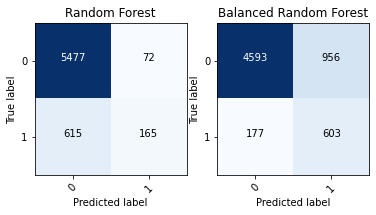

In [ ]:
y_pred_best_rf = best_rf.predict(X_test)
y_pred_best_brf = best_brf.predict(X_test)

# Similarly to the previous experiment, the balanced classifier outperform the
# classifier which learn from imbalanced bootstrap samples. In addition, random
# forest outsperforms the bagging classifier.
print('Random Forest classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_best_rf),
              geometric_mean_score(y_test, y_pred_best_rf)))
cm_best_rf = confusion_matrix(y_test, y_pred_best_rf)
fig, ax = plt.subplots(ncols=2) # 1 
plot_confusion_matrix(cm_best_rf, classes=np.unique(y), ax=ax[0],
                      title='Random Forest') # ax=ax

print('Balanced Random Forest classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_best_brf),
              geometric_mean_score(y_test, y_pred_best_brf)))
cm_best_brf = confusion_matrix(y_test, y_pred_best_brf)
plot_confusion_matrix(cm_best_brf, classes=np.unique(y), ax=ax[1],
                      title='Balanced Random Forest')

### B.3.2 Mean ROC AUC

In [ ]:
# Random Forest classifier
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1612)
# evaluate model
train_scores_best_rf = cross_val_score(best_rf, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
test_scores_best_rf = cross_val_score(best_rf, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)

# summarize performance
print('Mean ROC AUC on Train Set: %.3f' % mean(train_scores_best_rf))
print('Mean ROC AUC on Test Set: %.3f' % mean(test_scores_best_rf))

Mean ROC AUC on Train Set: 0.874
Mean ROC AUC on Test Set: 0.863


In [ ]:
# Balanced Random Forest classifier
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1612)
# evaluate model
train_scores_best_brf = cross_val_score(best_brf, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
test_scores_best_brf = cross_val_score(best_brf, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)

# summarize performance
print('Mean ROC AUC on Train Set: %.3f' % mean(train_scores_best_brf))
print('Mean ROC AUC on Test Set: %.3f' % mean(test_scores_best_brf))

Mean ROC AUC on Train Set: 0.877
Mean ROC AUC on Test Set: 0.858


### B.3.3 Accuracy scores on Train / Test Set

In [ ]:
print('Random Forest classifier score on Train Set: ' + str(best_rf.score(X_train, y_train)))
print('Random Forest classifier score on Test Set: ' + str(best_rf.score(X_test, y_test)))

Random Forest classifier score on Train Set: 0.9309037286707394
Random Forest classifier score on Test Set: 0.8916100489808817


In [ ]:
print('Balanced Random Forest classifier score on Train Set: ' + str(best_brf.score(X_train, y_train)))
print('Balanced Random Forest classifier score on Test Set: ' + str(best_brf.score(X_test, y_test)))

Balanced Random Forest classifier score on Train Set: 0.8786075416052244
Balanced Random Forest classifier score on Test Set: 0.8375730763153737


### B.3.4 Classification report

In [ ]:
y_pred_best_rf_train = best_rf.predict(X_train)
print('Accuracy score on Train Set of Best Random Forest: {0:0.5f}'. format(accuracy_score(y_train, y_pred_best_rf_train)))
print('Accuracy score on Test Set of Best Random Forest: {0:0.5f}'. format(accuracy_score(y_test, y_pred_best_rf)))
rf_precision_train = precision_score(y_train, y_pred_best_rf_train)
print('Precision score on Train Set of Best Random Forest: %f' % rf_precision_train)
rf_precision = precision_score(y_test, y_pred_best_rf)
print('Precision score on Test Set of Best Random Forest: %f' % rf_precision)
rf_recall_train = recall_score(y_train, y_pred_best_rf_train)
print('Recall score on Train Set of Best Random Forest: %f' % rf_recall_train)
rf_recall = recall_score(y_test, y_pred_best_rf)
print('Recall score on Test Set of Best Random Forest: %f' % rf_recall)
rf_f1_train = f1_score(y_train, y_pred_best_rf_train)
print('F1-score on Train Set of Best Random Forest: %f' % rf_f1_train)
rf_f1 = f1_score(y_test, y_pred_best_rf)
print('F1-score on Test Set of Best Random Forest: %f' % rf_f1)
print('\n')
print('Classification report on Train Set of Best Random Forest: ', '\n', classification_report(y_train, y_pred_best_rf_train))
print('\n')
print('Classification report on Test Set of Best Random Forest: ', '\n', classification_report(y_test, y_pred_best_rf))

Accuracy score on Train Set of Best Random Forest: 0.98641
Accuracy score on Test Set of Best Random Forest: 0.89240
Precision score on Train Set of Best Random Forest: 0.987780
Precision score on Test Set of Best Random Forest: 0.655172
Recall score on Train Set of Best Random Forest: 0.892364
Recall score on Test Set of Best Random Forest: 0.267949
F1-score on Train Set of Best Random Forest: 0.937651
F1-score on Test Set of Best Random Forest: 0.380346


Classification report on Train Set of Best Random Forest:  
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     16814
           1       0.99      0.89      0.94      2174

    accuracy                           0.99     18988
   macro avg       0.99      0.95      0.97     18988
weighted avg       0.99      0.99      0.99     18988



Classification report on Test Set of Best Random Forest:  
               precision    recall  f1-score   support

           0       0.90      0.98

In [ ]:
y_pred_best_brf_train = best_brf.predict(X_train)
print('Accuracy score on Train Set of Best Balanced Random Forest: {0:0.5f}'. format(accuracy_score(y_train, y_pred_best_brf_train)))
print('Accuracy score on Test Set of Best Balanced Random Forest: {0:0.5f}'. format(accuracy_score(y_test, y_pred_best_brf)))
brf_precision_train = precision_score(y_train, y_pred_best_brf_train)
print('Precision score on Train Set of Best Random Forest: %f' % brf_precision_train)
brf_precision = precision_score(y_test, y_pred_best_brf)
print('Precision score on Test Set of Best Random Forest: %f' % brf_precision)
brf_recall_train = recall_score(y_train, y_pred_best_brf_train)
print('Recall score on Train Set of Best Random Forest: %f' % brf_recall_train)
brf_recall = recall_score(y_test, y_pred_best_brf)
print('Recall score on Test Set of Best Random Forest: %f' % brf_recall)
brf_f1_train = f1_score(y_train, y_pred_best_brf_train)
print('F1-score on Train Set of Best Random Forest: %f' % brf_f1_train)
brf_f1 = f1_score(y_test, y_pred_best_brf)
print('F1-score on Test Set of Best Random Forest: %f' % brf_f1)
print('\n')
print('Classification report on Train Set of Best Balanced Random Forest: ', '\n', classification_report(y_train, y_pred_best_brf_train))
print('\n')
print('Classification report on Test Set of Best Balanced Random Forest: ', '\n', classification_report(y_test, y_pred_best_brf))

Accuracy score on Train Set of Best Balanced Random Forest: 0.89488
Accuracy score on Test Set of Best Balanced Random Forest: 0.84295
Precision score on Train Set of Best Random Forest: 0.521343
Precision score on Test Set of Best Random Forest: 0.426813
Recall score on Train Set of Best Random Forest: 1.000000
Recall score on Test Set of Best Random Forest: 0.800000
F1-score on Train Set of Best Random Forest: 0.685372
F1-score on Test Set of Best Random Forest: 0.556646


Classification report on Train Set of Best Balanced Random Forest:  
               precision    recall  f1-score   support

           0       1.00      0.88      0.94     16814
           1       0.52      1.00      0.69      2174

    accuracy                           0.89     18988
   macro avg       0.76      0.94      0.81     18988
weighted avg       0.95      0.89      0.91     18988



Classification report on Test Set of Best Balanced Random Forest:  
               precision    recall  f1-score   suppor

In [ ]:
# import joblib
model_best_rf = '/content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Final Project/Banking Dataset/model_best_rf.sav'
joblib.dump(best_rf, model_best_rf)
model_best_brf = '/content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Final Project/Banking Dataset/model_best_brf.sav'
joblib.dump(best_brf, model_best_brf)

['/content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Final Project/Banking Dataset/model_best_brf.sav']

## B.4. Boosting classifier (Easy Ensemble, RUS Boost, XGBoost)



In the same manner, Easy Ensemble classifier is a bag of balanced AdaBoost classifier. However, it will be slower to train than random forest and will achieve worse performance

https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.ensemble.EasyEnsembleClassifier.html

RUS Boost: Several methods taking advantage of boosting have been designed. RUSBoostClassifier randomly under-sample the dataset before to perform a boosting iteration. Random under-sampling integrating in the learning of an AdaBoost classifier. During learning, the problem of class balancing is alleviated by random under-sampling the sample at each iteration of the boosting algorithm.

https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.ensemble.RUSBoostClassifier.html?highlight=rusboost#imblearn.ensemble.RUSBoostClassifier

XGBoost provides a highly efficient implementation of the stochastic gradient boosting algorithm and access to a suite of model hyperparameters designed to provide control over the model training process.

https://machinelearningmastery.com/xgboost-for-imbalanced-classification/

#### B.4.1 Confusion Matrix

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Best params of Easy Ensemble:  {'warm_start': True, 'verbose': 0, 'sampling_strategy': 'auto', 'replacement': False, 'n_jobs': 1, 'n_estimators': 10}
Easy ensemble classifier performance:
Balanced accuracy: 0.84 - Geometric mean 0.84
[[4718  831]
 [ 131  649]]



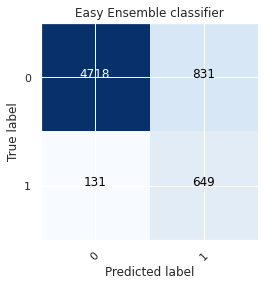

In [ ]:
# EEC: https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.ensemble.EasyEnsembleClassifier.html
from sklearn.model_selection import RandomizedSearchCV # "sampling_strategy": ['float', 'str', 'auto']
params_eec = {"warm_start": [True, False],
          "n_estimators": [5, 10],
          "sampling_strategy": ['float', 'auto'],
          "replacement": [True, False],
          "n_jobs": [1, -1],
          "verbose": [0, 1]}
base_estimator = AdaBoostClassifier()
eec = EasyEnsembleClassifier(random_state=1612, base_estimator=base_estimator)
rs_eec = RandomizedSearchCV(eec, params_eec, cv=5)
rs_eec.fit(X_train, y_train)
best_eec = rs_eec.fit(X_train, y_train)
print('Best params of Easy Ensemble: ', best_eec.best_params_)
y_pred_best_eec = best_eec.predict(X_test)
print('Easy ensemble classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_best_eec),
              geometric_mean_score(y_test, y_pred_best_eec)))
cm_eec = confusion_matrix(y_test, y_pred_best_eec)
fig, ax = plt.subplots(ncols=1)
plot_confusion_matrix(cm_eec, classes=np.unique(y), ax=ax,
                      title='Easy Ensemble classifier')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.6/dist-packages/imblearn/ensemble/_weight_boosting.py", line 170, in fit
    super().fit(X, y, sample_weight)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_weight_boosting.py", line 443, in fit
    return super().fit(X, y, sample_weight)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_weight_boosting.py", line 134, in fit
    random_state)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_weight_boosting.py", line 507, in _boost
    random_state)
  File "/usr/local/lib/python3.6/dist-packages/imblea

Best params of RUS Boost:  {'sampling_strategy': 'auto', 'replacement': False, 'n_estimators': 10, 'algorithm': 'SAMME.R'}
RUS Boost classifier performance:
Balanced accuracy: 0.84 - Geometric mean 0.84
[[4721  828]
 [ 132  648]]



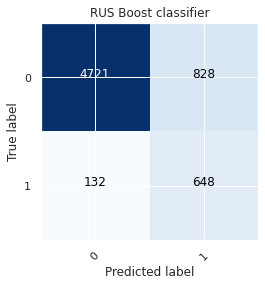

In [ ]:
# RUS Boost: https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.ensemble.RUSBoostClassifier.html
params_rusboost = {"n_estimators": [5, 10],
          "algorithm": ['SAMME', 'SAMME.R'],
          "sampling_strategy": ['float', 'auto'],
          "replacement": [True, False]}
rusboost = RUSBoostClassifier(random_state=1612, base_estimator=base_estimator)
rs_rusboost = RandomizedSearchCV(rusboost, params_rusboost, cv=5)
rs_rusboost.fit(X_train, y_train)
best_rusboost = rs_rusboost.fit(X_train, y_train)
print('Best params of RUS Boost: ', best_rusboost.best_params_)
y_pred_best_rusboost = best_rusboost.predict(X_test)
print('RUS Boost classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_best_rusboost),
              geometric_mean_score(y_test, y_pred_best_rusboost)))
cm_rusboost = confusion_matrix(y_test, y_pred_best_rusboost)
fig, ax = plt.subplots(ncols=1)
plot_confusion_matrix(cm_rusboost, classes=np.unique(y), ax=ax,
                      title='RUS Boost classifier')

Best params of XGBoost:  {'subsample': 0.8, 'n_estimators': 10, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 0.8}
best_xgboost Classifier performance:
Balanced accuracy: 0.61 - Geometric mean 0.49
[[5477   72]
 [ 592  188]]



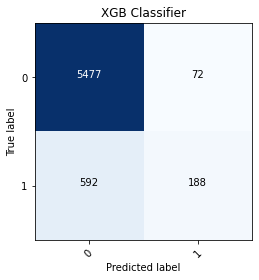

In [ ]:
# https://machinelearningmastery.com/xgboost-for-imbalanced-classification/
# https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost       
# https://www.kaggle.com/saxinou/imbalanced-data-xgboost-tunning
from sklearn.model_selection import RandomizedSearchCV

params = {
        'min_child_weight': [1, 5],
        'n_estimators': [5, 10], 
        'gamma': [0.5, 1],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.8],
        'max_depth': [3, 4],
        'learning_rate': [0.01, 0.05]
        }

XGB = XGBClassifier(random_state=1612) # random_state=1612, n_jobs=-1
rs_xgboost = RandomizedSearchCV(XGB, params, cv=5)
rs_xgboost.fit(X_train, y_train)
best_xgboost = rs_xgboost.fit(X_train, y_train)
print('Best params of XGBoost: ', best_xgboost.best_params_)

y_pred_best_xgboost = best_xgboost.predict(X_test)

# Similarly to the previous experiment, the balanced classifier outperform the
# classifier which learn from imbalanced bootstrap samples. In addition, random
# forest outsperforms the bagging classifier.

print('best_xgboost Classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_best_xgboost),
              geometric_mean_score(y_test, y_pred_best_xgboost)))
cm_best_xgboost = confusion_matrix(y_test, y_pred_best_xgboost)
fig, ax = plt.subplots(ncols=1)
plot_confusion_matrix(cm_best_xgboost, classes=np.unique(y), ax=ax,
                      title='XGB Classifier')

### B.4.2 Mean ROC AUC 

In [ ]:
# Easy Ensemble for imbalanced classification
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1612)
# evaluate model eec
train_scores_best_eec = cross_val_score(best_eec, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
test_scores_best_eec = cross_val_score(best_eec, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC on Train Set: %.3f' % mean(train_scores_best_eec))
print('Mean ROC AUC on Test Set: %.3f' % mean(test_scores_best_eec))

Mean ROC AUC on Train Set: 0.909
Mean ROC AUC on Test Set: 0.911


In [ ]:
# RUS Boost
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1612)
# evaluate model rusboost
train_scores_best_rusboost = cross_val_score(best_rusboost, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
test_scores_best_rusboost = cross_val_score(best_rusboost, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC on Train Set: %.3f' % mean(train_scores_best_rusboost))
print('Mean ROC AUC on Test Set: %.3f' % mean(test_scores_best_rusboost))

Mean ROC AUC on Train Set: 0.908
Mean ROC AUC on Test Set: 0.909


In [ ]:
# XGBoost classifier
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1612)
# evaluate model
train_scores_best_xgboost = cross_val_score(best_xgboost, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
test_scores_best_xgboost = cross_val_score(best_xgboost, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)

# summarize performance
print('Mean ROC AUC on Train Set: %.3f' % mean(train_scores_best_xgboost))
print('Mean ROC AUC on Test Set: %.3f' % mean(test_scores_best_xgboost))

Mean ROC AUC on Train Set: 0.875
Mean ROC AUC on Test Set: 0.877


### B.4.3 Accuracy scores on Train / Test Set

In [ ]:
print('Easy Ensemble Classifier score on Train Set: ' + str(best_eec.score(X_train, y_train)))
print('Easy Ensemble Classifier score on Test Set: ' + str(best_eec.score(X_test, y_test)))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Easy Ensemble Classifier score on Train Set: 0.8427954497577417
Easy Ensemble Classifier score on Test Set: 0.8480012640227524


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.9s finished


In [ ]:
print('RUS Boost score on Train Set: ' + str(best_rusboost.score(X_train, y_train)))
print('RUS Boost score on Test Set: ' + str(best_rusboost.score(X_test, y_test)))

RUS Boost score on Train Set: 0.8446913840320203
RUS Boost score on Test Set: 0.849265286775162


In [ ]:
print('XGBoost classifier score on Train Set: ' + str(best_xgboost.score(X_train, y_train)))
print('XGBoost classifier score on Test Set: ' + str(best_xgboost.score(X_test, y_test)))

XGBoost classifier score on Train Set: 0.9014640825784707
XGBoost classifier score on Test Set: 0.8931900774213936


### B.4.4 Classification report

In [ ]:
y_pred_best_eec_train = best_eec.predict(X_train)
print('Accuracy score on Train Set of Best Easy Ensemble: {0:0.5f}'. format(accuracy_score(y_train, y_pred_best_eec_train)))
print('Accuracy score on Test Set of Best Easy Ensemble: {0:0.5f}'. format(accuracy_score(y_test, y_pred_best_eec)))
eec_precision_train = precision_score(y_train, y_pred_best_eec_train)
print('Precision score on Train Set of Best Easy Ensemble: %f' % eec_precision_train)
eec_precision = precision_score(y_test, y_pred_best_eec)
print('Precision score on Test Set of Best Easy Ensemble: %f' % eec_precision)
eec_recall_train = recall_score(y_train, y_pred_best_eec_train)
print('Recall score on Train Set of Best Easy Ensemble: %f' % eec_recall_train)
eec_recall = recall_score(y_test, y_pred_best_eec)
print('Recall score on Test Set of Best Easy Ensemble: %f' % eec_recall)
eec_f1_train = f1_score(y_train, y_pred_best_eec_train)
print('F1-score score on Train Set of Best Easy Ensemble: %f' % eec_f1_train)
eec_f1 = f1_score(y_test, y_pred_best_eec)
print('F1-score score on Test Set of Best Easy Ensemble: %f' % eec_f1)
print('\n')
print('Classification report on Train Set of Best Easy Ensemble: ', '\n', classification_report(y_test, y_pred_best_eec))
print('\n')
print('Classification report on Test Set of Best Easy Ensemble: ', '\n', classification_report(y_test, y_pred_best_eec))

Accuracy score on Train Set of Best Easy Ensemble: 0.84438
Accuracy score on Test Set of Best Easy Ensemble: 0.84784
Precision score on Train Set of Best Easy Ensemble: 0.410824
Precision score on Test Set of Best Easy Ensemble: 0.438134
Recall score on Train Set of Best Easy Ensemble: 0.827507
Recall score on Test Set of Best Easy Ensemble: 0.830769
F1-score score on Train Set of Best Easy Ensemble: 0.549061
F1-score score on Test Set of Best Easy Ensemble: 0.573705


Classification report on Train Set of Best Easy Ensemble:  
               precision    recall  f1-score   support

           0       0.97      0.85      0.91      5549
           1       0.44      0.83      0.57       780

    accuracy                           0.85      6329
   macro avg       0.71      0.84      0.74      6329
weighted avg       0.91      0.85      0.87      6329



Classification report on Test Set of Best Easy Ensemble:  
               precision    recall  f1-score   support

           0       0.

In [ ]:
y_pred_best_rusboost_train = best_rusboost.predict(X_train)
print('Accuracy score on Train Set of Best RUS Boost: {0:0.5f}'. format(accuracy_score(y_train, y_pred_best_rusboost_train)))
print('Accuracy score on Test Set of Best RUS Boost: {0:0.5f}'. format(accuracy_score(y_test, y_pred_best_rusboost)))
rusboost_precision_train = precision_score(y_train, y_pred_best_rusboost_train)
print('Precision score on Train Set of Best RUS Boost: %f' % rusboost_precision_train)
rusboost_precision = precision_score(y_test, y_pred_best_rusboost)
print('Precision score on Test Set of Best RUS Boost: %f' % rusboost_precision)
rusboost_recall_train = recall_score(y_train, y_pred_best_rusboost_train)
print('Recall on Train Set of Best RUS Boost: %f' % rusboost_recall_train)
rusboost_recall = recall_score(y_test, y_pred_best_rusboost)
print('Recall on Test Set of Best RUS Boost: %f' % rusboost_recall)
rusboost_f1_train = f1_score(y_train, y_pred_best_rusboost_train)
print('F1-score on Train Set of Best RUS Boost: %f' % rusboost_f1_train)
rusboost_f1 = f1_score(y_test, y_pred_best_rusboost)
print('F1-score on Test Set of Best RUS Boost: %f' % rusboost_f1)
print('\n')
print('Classification report on Train Set of Best RUS Boost: ', classification_report(y_train, y_pred_best_rusboost_train))
print('\n')
print('Classification report on Test Set of Best RUS Boost: ', classification_report(y_test, y_pred_best_rusboost))

Accuracy score on Train Set of Best RUS Boost: 0.84511
Accuracy score on Test Set of Best RUS Boost: 0.84832
Precision score on Train Set of Best RUS Boost: 0.412343
Precision score on Test Set of Best RUS Boost: 0.439024
Recall on Train Set of Best RUS Boost: 0.829807
Recall on Test Set of Best RUS Boost: 0.830769
F1-score on Train Set of Best RUS Boost: 0.550924
F1-score on Test Set of Best RUS Boost: 0.574468


Classification report on Train Set of Best RUS Boost:                precision    recall  f1-score   support

           0       0.97      0.85      0.91     16814
           1       0.41      0.83      0.55      2174

    accuracy                           0.85     18988
   macro avg       0.69      0.84      0.73     18988
weighted avg       0.91      0.85      0.87     18988



Classification report on Test Set of Best RUS Boost:                precision    recall  f1-score   support

           0       0.97      0.85      0.91      5549
           1       0.44      0.83  

In [ ]:
y_pred_best_xgboost_train = best_xgboost.predict(X_train)
print('Accuracy score on Train Set of Best XGBoost: {0:0.5f}'. format(accuracy_score(y_train, y_pred_best_xgboost_train)))
print('Accuracy score on Test Set of Best XGBoost: {0:0.5f}'. format(accuracy_score(y_test, y_pred_best_xgboost)))
xgboost_precision_train = precision_score(y_train, y_pred_best_xgboost_train)
print('Precision score on Train Set of Best XGBoost: %f' % xgboost_precision_train)
xgboost_precision = precision_score(y_test, y_pred_best_xgboost)
print('Precision score on Test Set of Best XGBoost: %f' % xgboost_precision)
xgboost_recall_train = recall_score(y_train, y_pred_best_xgboost_train)
print('Recall score on Train Set of Best XGBoost: %f' % xgboost_recall_train)
xgboost_recall = recall_score(y_test, y_pred_best_xgboost)
print('Recall score on Test Set of Best XGBoost: %f' % xgboost_recall)
xgboost_f1_train = f1_score(y_train, y_pred_best_xgboost_train)
print('F1-score score on Train Set of Best XGBoost: %f' % xgboost_f1_train)
xgboost_f1 = f1_score(y_test, y_pred_best_xgboost)
print('F1-score score on Test Set of Best XGBoost: %f' % xgboost_f1)
print('\n')
print('Classification report on Train Set of Best XGBoost: ', '\n', classification_report(y_train, y_pred_best_xgboost_train))
print('\n')
print('Classification report on Test Set of Best XGBoost: ', '\n', classification_report(y_test, y_pred_best_xgboost))

Accuracy score on Train Set of Best XGBoost: 0.90041
Accuracy score on Test Set of Best XGBoost: 0.89082
Precision score on Train Set of Best XGBoost: 0.822323
Precision score on Test Set of Best XGBoost: 0.790850
Recall score on Train Set of Best XGBoost: 0.166053
Recall score on Test Set of Best XGBoost: 0.155128
F1-score score on Train Set of Best XGBoost: 0.276311
F1-score score on Test Set of Best XGBoost: 0.259378


Classification report on Train Set of Best XGBoost:  
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     16814
           1       0.82      0.17      0.28      2174

    accuracy                           0.90     18988
   macro avg       0.86      0.58      0.61     18988
weighted avg       0.89      0.90      0.87     18988



Classification report on Test Set of Best XGBoost:  
               precision    recall  f1-score   support

           0       0.89      0.99      0.94      5549
           1       0.79    

In [ ]:
# import joblib
model_best_eec = '/content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Final Project/Banking Dataset/model_best_eec.sav'
joblib.dump(best_eec, model_best_eec)

['/content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Final Project/Banking Dataset/model_best_eec.sav']

In [ ]:
model_best_rusboost = '/content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Final Project/Banking Dataset/model_best_rusboost.sav'
joblib.dump(best_rusboost, model_best_rusboost)

['/content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Final Project/Banking Dataset/model_best_rusboost.sav']

In [ ]:
model_best_xgboost = '/content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Final Project/Banking Dataset/model_best_xgboost.sav'
joblib.dump(best_xgboost, model_best_xgboost)

['/content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Final Project/Banking Dataset/model_best_xgboost.sav']

## B.5. Create DNN Model to compare with different kinds of Trees and Forests

### B.5.1 Scale data

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [ ]:
print(X_train_scaled.shape)
print(X_val_scaled.shape)
print(y_train.shape)
print(y_val.shape)

(18988, 51)
(6330, 51)
(18988,)
(6330,)


### B.5.2 DNN Model

In [ ]:
# from tensorflow.keras.layers import Dense, Input
# from tensorflow.keras.models import Sequential, Model
# import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, BatchNormalization

def make_model(n_features):
    model = Sequential()
    model.add(Dense(200, input_shape=(n_features,),
              kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100, kernel_initializer='glorot_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(50, kernel_initializer='glorot_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.15))
    model.add(Dense(25, kernel_initializer='glorot_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [ ]:
# imblearn.show_versions()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
tuned_model = make_model(X_train_scaled.shape[1])
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
tuned_history = tuned_model.fit(X_train_scaled, y_train, epochs=1000, validation_data=(X_val_scaled, y_val), batch_size=512, shuffle=True, callbacks=[early_stop]) # để sau cùng: truyền vào array

# dnn_model = make_model(X_train_scaled.shape[1])
# history = dnn_model.fit(X_train_scaled, y_train, epochs=5, verbose=1, validation_data=(X_val_scaled, y_val), batch_size=1000)

Epoch 1/1000
38/38 [==============================] - 1s 23ms/step - loss: 0.5165 - accuracy: 0.7912 - val_loss: 0.5778 - val_accuracy: 0.8498
Epoch 2/1000
38/38 [==============================] - 1s 16ms/step - loss: 0.3817 - accuracy: 0.8776 - val_loss: 0.4517 - val_accuracy: 0.8891
Epoch 3/1000
38/38 [==============================] - 1s 15ms/step - loss: 0.3224 - accuracy: 0.8890 - val_loss: 0.3538 - val_accuracy: 0.8940
Epoch 4/1000
38/38 [==============================] - 1s 16ms/step - loss: 0.2912 - accuracy: 0.8939 - val_loss: 0.2940 - val_accuracy: 0.8942
Epoch 5/1000
38/38 [==============================] - 1s 16ms/step - loss: 0.2713 - accuracy: 0.8964 - val_loss: 0.2532 - val_accuracy: 0.8979
Epoch 6/1000
38/38 [==============================] - 1s 16ms/step - loss: 0.2612 - accuracy: 0.8975 - val_loss: 0.2343 - val_accuracy: 0.8983
Epoch 7/1000
38/38 [==============================] - 1s 16ms/step - loss: 0.2534 - accuracy: 0.8971 - val_loss: 0.2266 - val_accuracy: 0.8972

In [ ]:
y_pred = tuned_model.predict(X_test, batch_size=1000)

In [ ]:
print(y_pred)

[[9.9765897e-01]
 [9.9888361e-01]
 [1.0000000e+00]
 ...
 [6.1176913e-21]
 [9.8954880e-01]
 [9.9998754e-01]]


In [ ]:
# input = Input(shape=X_train_scaled.shape[1:])
# dense = Dense(64, activation='relu')(input)
# dense = Dense(64, activation='relu')(dense)
# output = Dense(1, activation='sigmoid')(dense)
# dnn_model = Model(input, output)
# dnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
# history = dnn_model.fit(X_train_scaled, y_train, epochs=5, validation_data=(X_val_scaled, y_val))

### B.5.3 Draw Learning Curve

In [ ]:
def draw_chart(history):
  plt.figure(figsize=(15,8))
  
  plt.subplot(1,2,1)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Losses vs Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(['Train', 'Validation'])

  plt.subplot(1,2,2)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Accuracy vs Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['Train', 'Validation'])

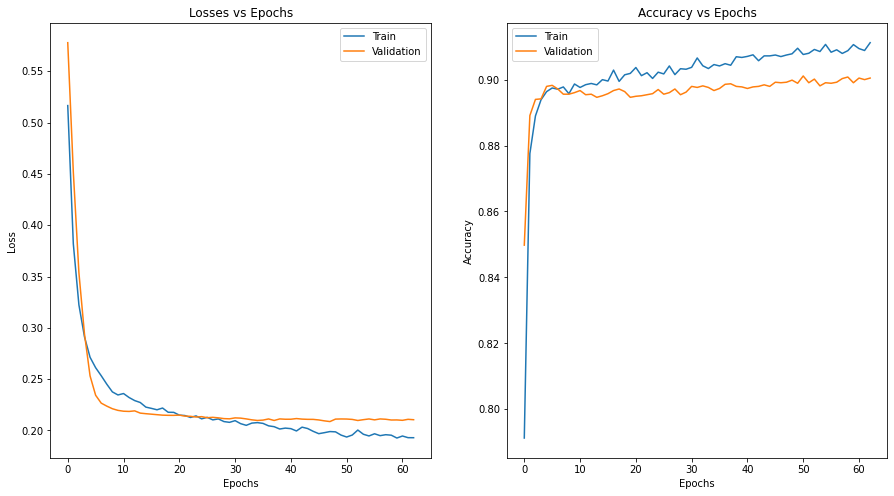

In [ ]:
draw_chart(tuned_history)

In [ ]:
tuned_model.evaluate(X_train, y_train)
tuned_model.evaluate(X_val, y_val)
tuned_model.evaluate(X_test, y_test)

198/198 [==============================] - 0s 2ms/step - loss: 28.4664 - accuracy: 0.4061


[28.46639060974121, 0.4060673117637634]

### B.5.4 Confusion Matrix

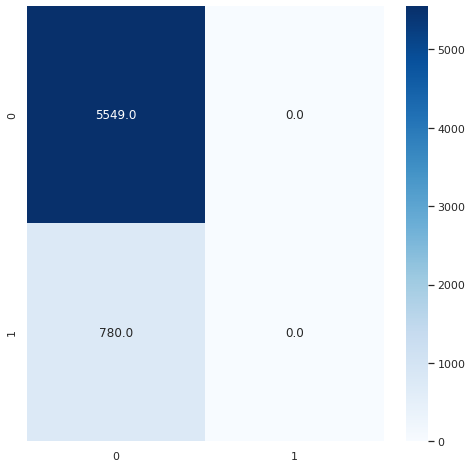

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()

y_pred = tuned_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm_cnn = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,8))
sns.heatmap(cm_cnn, annot=True, 
            cmap='Blues', fmt='.1f')

### B.5.5. Scores of DNN Model

In [ ]:
# y_pred = y_pred.astype(np.int64)
# y_pred.dtype

dtype('int64')

In [ ]:
# https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/
# Accuracy: (TP + TN) / (P + N)
accuracy = accuracy_score(y_test, y_pred.round())
print('Accuracy: %f' % accuracy)
# Precision: TP / (TP + FP)
precision = precision_score(y_test, y_pred.round())
print('Precision of DNN Model: %f' % precision)
# Recall: TP / (TP + FN)
recall = recall_score(y_test, y_pred.round())
print('Recall DNN Model: %f' % recall)
# F1: 2 TP / (2 TP + FP + FN)
f1 = f1_score(y_test, y_pred.round())
print('F1-score DNN Model: %f' % f1)
print('Balanced accuracy of DNN Model: {:.2f} - Geometric mean of DNN Model: {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred.round()),
              geometric_mean_score(y_test, y_pred.round())))

Accuracy: 0.876758
Precision of DNN Model: 0.000000
Recall DNN Model: 0.000000
F1-score DNN Model: 0.000000
Balanced accuracy of DNN Model: 0.50 - Geometric mean of DNN Model: 0.00


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
tuned_model.save('/content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Final Project/Banking Dataset/model_dnn')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Final Project/Banking Dataset/model_dnn/assets


RUS Boost has the highest F1-score, Recall score, Balanced accuracy and Geometric mean among all classifiers. 

# C. Draw Feature Importance

Permutation Importance with Multicollinear or Correlated Features:

https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

Permutation Importance vs Random Forest Feature Importance (MDI):

https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

In [ ]:
import seaborn as sns
def drawFeatureImportance(model, title, n_top):
  importances = pd.DataFrame({'feature': X_train.columns,'importance':np.round(model.best_estimator_.feature_importances_,3)}) # https://stackoverflow.com/questions/47111434/randomforestregressor-and-feature-importances-error
  importances = importances.sort_values('importance', ascending=False).head(n_top)
  plt.figure(figsize=(15,5))
  sns.barplot(y=importances['feature'], x=importances['importance']).set_title(title)

## C.1. Feature Importance of Single Decision Tree

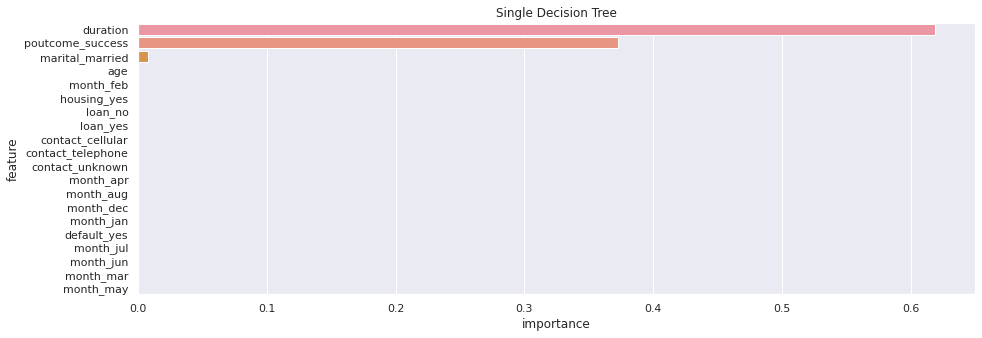

In [ ]:
drawFeatureImportance(rs_decision_tree, 'Single Decision Tree', 20)

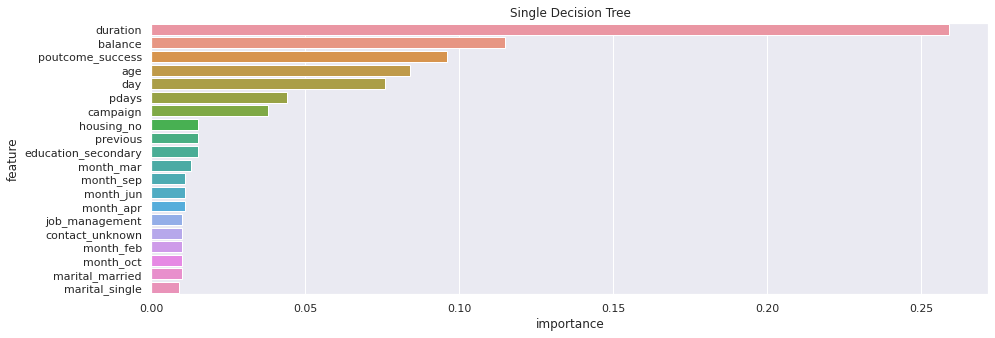

In [ ]:
drawFeatureImportance(decision_tree, 'Single Decision Tree', 20)

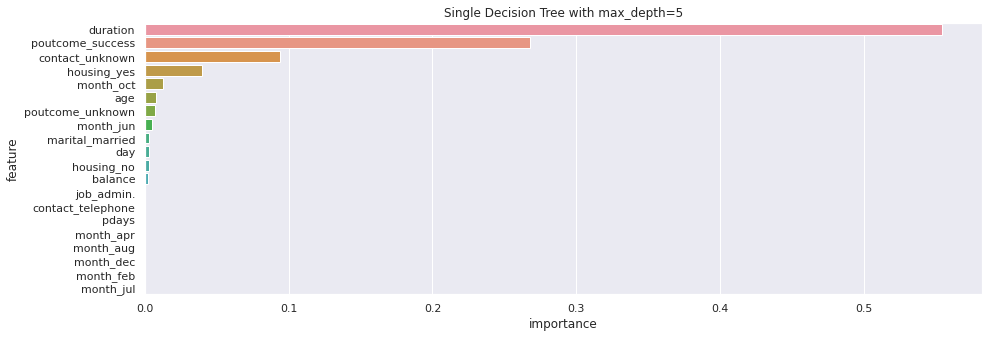

In [ ]:
drawFeatureImportance(dectree, 'Single Decision Tree with max_depth=5', 20)

There is no Feature Importance of Bagging Classifier

In [ ]:
# drawFeatureImportance(bagging, 'Bagging Classifier', 20)

There is no Feature Importance of Balanced Bagging Classifier 

In [ ]:
# drawFeatureImportance(balanced_bagging, 'Balanced Bagging Classifier', 20)

In [ ]:
# Alternative method for Balanced Bagging Classifer's Feature Importance
# brf.feature_importances_  

In [ ]:
# importance_balanced_bagging = pd.DataFrame({'feature': X_train.columns,'importance':np.round(balanced_bagging.feature_importances_,3)})
# importance_balanced_bagging = importance_balanced_bagging.sort_values('importance', ascending=False).head(20)
# sns.barplot(y=importance_balanced_bagging['feature'], x=importance_balanced_bagging['importance']).set_title('Balanced Random Forest')

## C.2. Feature Importance of Random Forest

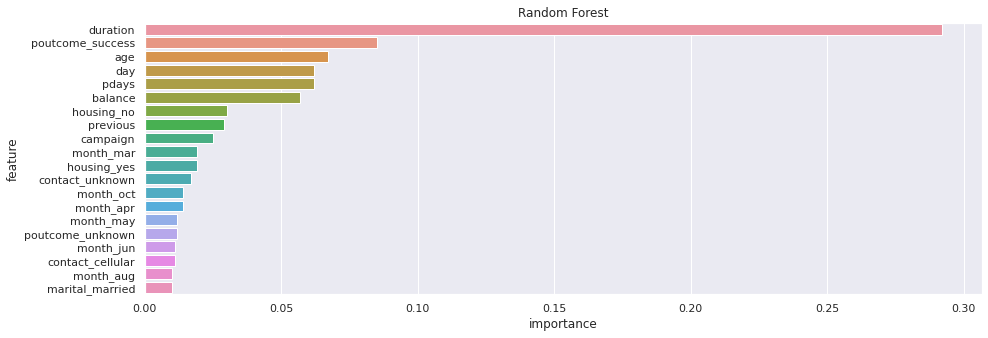

In [ ]:
drawFeatureImportance(rs_rf, 'Random Forest', 20)

In [ ]:
# # Alternative method for Bagging Classifer's Feature Importance
# # https://machinelearningmastery.com/calculate-feature-importance-with-python/
# # https://scikit-learn.org/stable/modules/ensemble.html
# # https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py
# importance_rf = rf.feature_importances_
# # summarize feature importance
# for i,v in enumerate(importance_rf):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# plt.figure(figsize=(20,10))
# plt.bar([x for x in range(len(importance_rf))], importance_rf) # thay x bằng tên cột[x], sort tên cột & sort importance by same order
# plt.show()
# print(importance_rf.dtype)

## C.3. Feature Importance of Balanced Random Forest

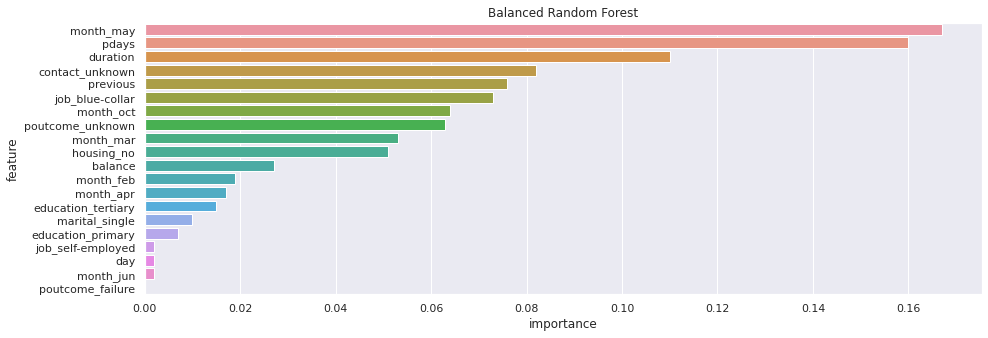

In [ ]:
drawFeatureImportance(rs_brf, 'Balanced Random Forest', 20)

Feature Importance of Easy Ensemble Classifier

In [ ]:
# drawFeatureImportance(rs_eec, 'Easy Ensemble Classifier', 20)

## C.4. Feature Importance of RUS Boost

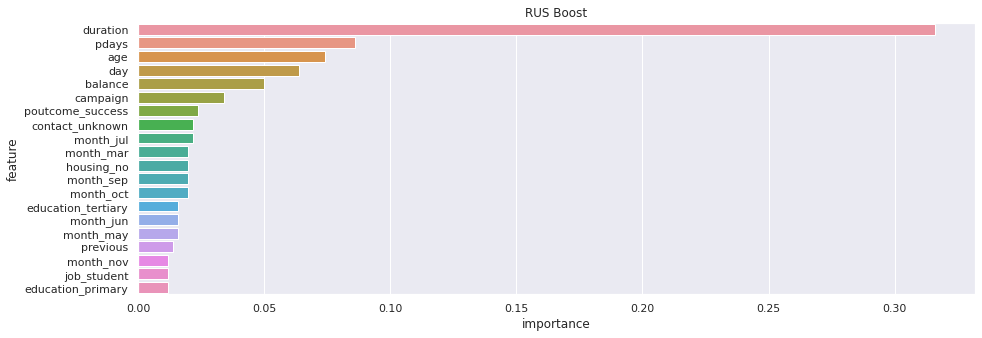

In [ ]:
drawFeatureImportance(rs_rusboost, 'RUS Boost', 20)

## C.5. Feature Importance of XGBoost

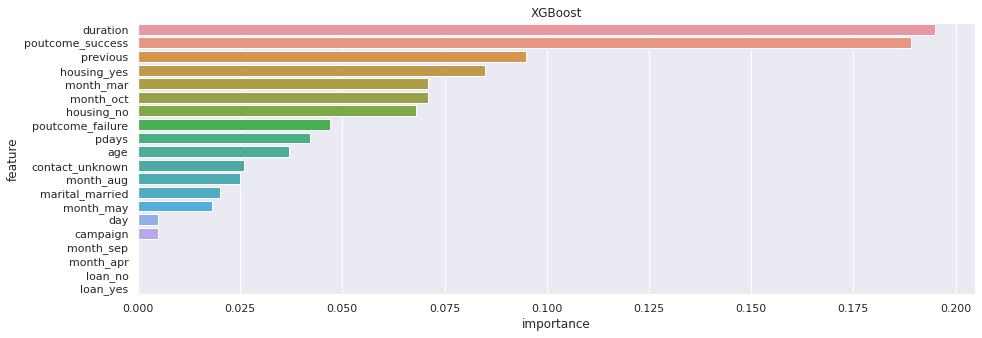

In [ ]:
drawFeatureImportance(rs_xgboost, 'XGBoost', 20)

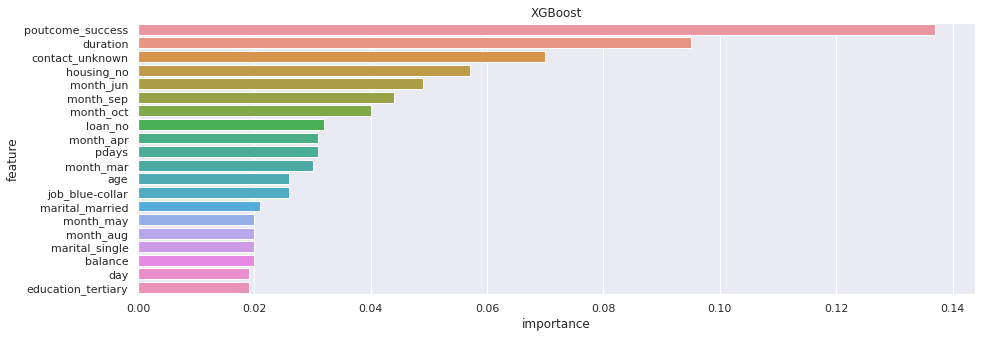

In [ ]:
drawFeatureImportance(xgboost, 'XGBoost', 20)

'Duration' seems to be the most important feature and 'poutcome_success' is likely the second most essential one among all classification methods.

# D. Heatmap

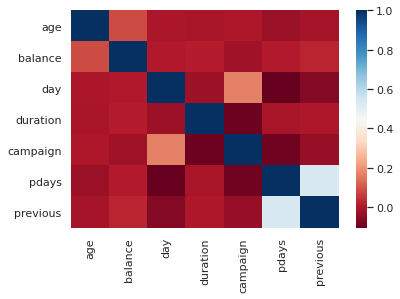

In [ ]:
sns.heatmap(df_test.corr(), cmap="RdBu")

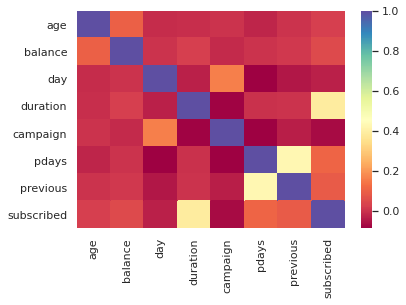

In [ ]:
sns.heatmap(df_train.corr(), cmap="Spectral")

# E. Draw Tree

In [ ]:
# !pip install --upgrade scikit-learn==0.23.2

Requirement already up-to-date: scikit-learn==0.23.2 in /usr/local/lib/python3.6/dist-packages (0.23.2)


In [ ]:
pip install --upgrade scikit-learn==0.20.3

     |████████████████████████████████| 5.4MB 2.2MB/s 
ERROR: imbalanced-learn 0.7.0 has requirement scikit-learn>=0.23, but you'll have scikit-learn 0.20.3 which is incompatible.
  Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2


In [ ]:
# https://www.kaggle.com/hamelg/python-for-data-29-decision-trees
# https://www.kdnuggets.com/2020/04/visualizing-decision-trees-python.html
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

# draw tree
def drawTree(model):
  dot_data = StringIO()
  export_graphviz(model, out_file=dot_data,  
                  filled=True, rounded=True,
                  special_characters=True,
                  feature_names = X_train.columns,
                  class_names=[str(x) for x in model.classes_]
                  )
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
  return graph.create_png()

## E.1 Tree of Single Decision Tree

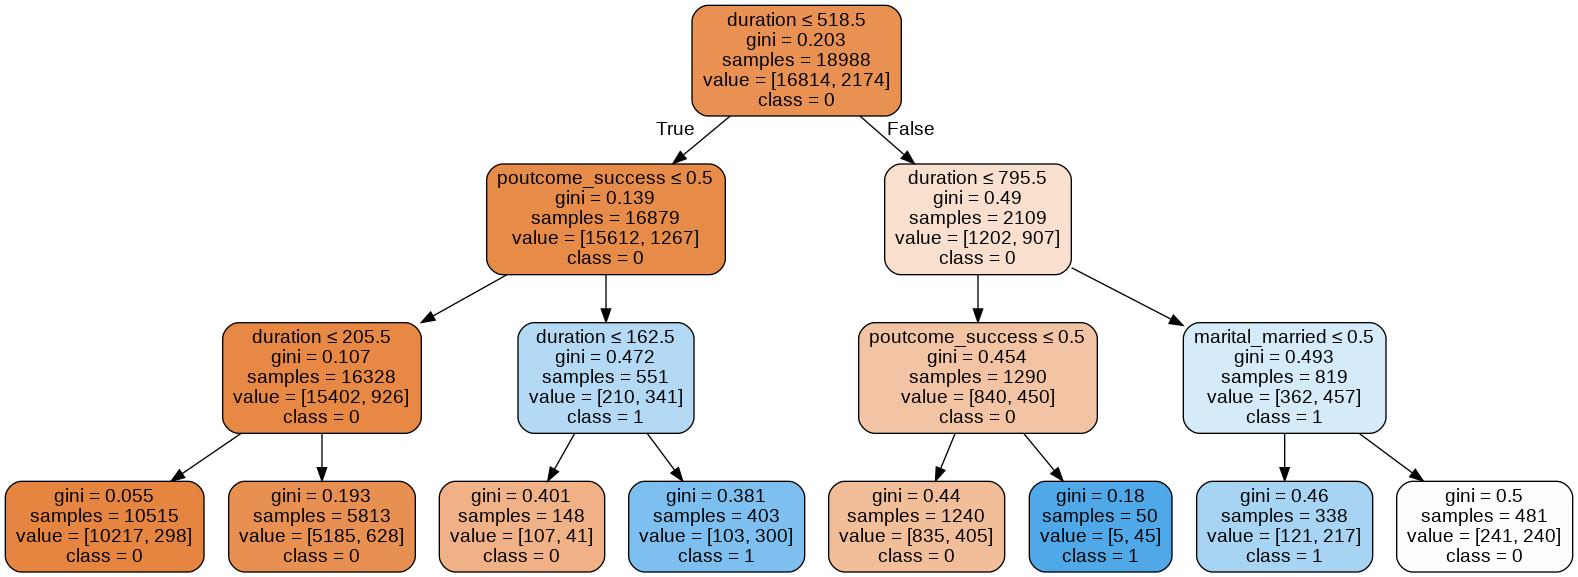

In [ ]:
Image(drawTree(best_decision_tree))

In [ ]:
# Image(drawTree(decision_tree))

In [ ]:
# Image(drawTree(dectree))

# F. ROC & AUC between Deep Neural Network, Ensemble Classifiers XGBoost Classifier

In [ ]:
# ROC & AUC
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# pred_proba = model.predict_proba(X_val)
# print('AUC: ' + str(roc_auc_score(y_val, pred_proba[:,1])))

# Probs:
nomodel_probs = [0 for _ in range(len(y_val))]

best_mlp_probs = tuned_model.predict(X_val_scaled)[:, 0]

decisiontree_probs = best_decision_tree.predict_proba(X_val)[:, 1]
bagging_probs = best_bagging.predict_proba(X_val)[:, 1]
balanced_bagging_probs = best_balanced_bagging.predict_proba(X_val)[:, 1]
randomforest_probs = best_rf.predict_proba(X_val)[:, 1]
balanced_randomforest_probs = best_brf.predict_proba(X_val)[:, 1]
xgboost_probs = best_xgboost.predict_proba(X_val)[:, 1]
eec_probs = best_eec.predict_proba(X_val)[:, 1]
rusboost_probs = best_rusboost.predict_proba(X_val)[:, 1]

best_probs = [x for x in y_val]

# AUC: 
nomodel_auc = roc_auc_score(y_val, nomodel_probs)
mlp_auc = roc_auc_score(y_val, best_mlp_probs)

decisiontree_auc = roc_auc_score(y_val, decisiontree_probs)
bagging_auc = roc_auc_score(y_val, bagging_probs)
balanced_bagging_auc = roc_auc_score(y_val, balanced_bagging_probs)
randomforest_auc = roc_auc_score(y_val, randomforest_probs)
balanced_randomforest_auc = roc_auc_score(y_val, balanced_randomforest_probs)
eec_auc = roc_auc_score(y_val, eec_probs)
rusboost_auc = roc_auc_score(y_val, rusboost_probs)
xgboost_auc = roc_auc_score(y_val, xgboost_probs)
best_auc = roc_auc_score(y_val, best_probs)

# Summarize scores:
print('No Skill: ROC AUC=%.3f' % (nomodel_auc))
print('With MLP: ROC AUC=%.3f' % (mlp_auc))
print('With Decision Tree: ROC AUC=%.3f' % (decisiontree_auc))
print('With Bagging: ROC AUC=%.3f' % (bagging_auc))
print('With Balanced Bagging: ROC AUC=%.3f' % (balanced_bagging_auc))
print('With Random Forest: ROC AUC=%.3f' % (randomforest_auc))
print('With Balanced Random Forest: ROC AUC=%.3f' % (balanced_randomforest_auc))
print('With Easy Ensemble: ROC AUC=%.3f' % (eec_auc))
print('With RUS Boost: ROC AUC=%.3f' % (rusboost_auc))
print('With XGBoost: ROC AUC=%.3f' % (xgboost_auc))
print('Best: ROC AUC=%.3f' % (best_auc))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.2s finished


No Skill: ROC AUC=0.500
With MLP: ROC AUC=0.928
With Decision Tree: ROC AUC=0.822
With Bagging: ROC AUC=0.739
With Balanced Bagging: ROC AUC=0.808
With Random Forest: ROC AUC=0.906
With Balanced Random Forest: ROC AUC=0.796
With Easy Ensemble: ROC AUC=0.916
With RUS Boost: ROC AUC=0.918
With XGBoost: ROC AUC=0.882
Best: ROC AUC=1.000


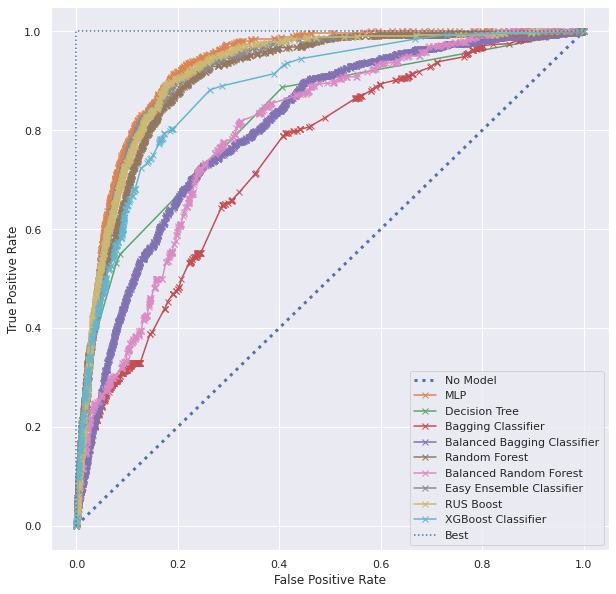

In [ ]:
# Calculate ROC Curves
nomodel_fpr, nomodel_tpr, _ = roc_curve(y_val, nomodel_probs)
mlp_fpr, mlp_tpr, _ = roc_curve(y_val, best_mlp_probs)
decisiontree_fpr, decisiontree_tpr, _ = roc_curve(y_val, decisiontree_probs)
bagging_fpr, bagging_tpr, _ = roc_curve(y_val, bagging_probs)
balanced_bagging_fpr, balanced_bagging_tpr, _ = roc_curve(y_val, balanced_bagging_probs)
randomforest_fpr, randomforest_tpr, _ = roc_curve(y_val, randomforest_probs)
balanced_randomforest_fpr, balanced_randomforest_tpr, _ = roc_curve(y_val, balanced_randomforest_probs)
eec_fpr, eec_tpr, _ = roc_curve(y_val, eec_probs)
rusboost_fpr, rusboost_tpr, _ = roc_curve(y_val, rusboost_probs)
xgboost_fpr, xgboost_tpr, _ = roc_curve(y_val, xgboost_probs)
best_fpr, best_tpr, _ = roc_curve(y_val, best_probs)

plt.figure(figsize=(10,10))
# plot the roc curve for the model
plt.plot(nomodel_fpr, nomodel_tpr, linestyle=':',linewidth=3, label='No Model')

plt.plot(mlp_fpr, mlp_tpr, marker='x', label='MLP')
plt.plot(decisiontree_fpr, decisiontree_tpr, marker='x', label='Decision Tree')
plt.plot(bagging_fpr, bagging_tpr, marker='x', label='Bagging Classifier')
plt.plot(balanced_bagging_fpr, balanced_bagging_tpr, marker='x', label='Balanced Bagging Classifier')
plt.plot(randomforest_fpr, randomforest_tpr, marker='x', label='Random Forest')
plt.plot(balanced_randomforest_fpr, balanced_randomforest_tpr, marker='x', label='Balanced Random Forest')
plt.plot(eec_fpr, eec_tpr, marker='x', label='Easy Ensemble Classifier')
plt.plot(rusboost_fpr, rusboost_tpr, marker='x', label='RUS Boost')
plt.plot(xgboost_fpr, xgboost_tpr, marker='x', label='XGBoost Classifier')
plt.plot(best_fpr, best_tpr, linestyle=':', label='Best')

# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Show the legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# ROC & AUC
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# pred_proba = model.predict_proba(X_val)
# print('AUC: ' + str(roc_auc_score(y_val, pred_proba[:,1])))

# Probs:
nomodel_probs = [0 for _ in range(len(y_val))]

mlp_probs = dnn_model.predict(X_val_scaled)[:, 0]

decisiontree_probs = decision_tree.predict_proba(X_val)[:, 1]
bagging_probs = bagging.predict_proba(X_val)[:, 1]
balanced_bagging_probs = balanced_bagging.predict_proba(X_val)[:, 1]
randomforest_probs = rf.predict_proba(X_val)[:, 1]
balanced_randomforest_probs = brf.predict_proba(X_val)[:, 1]
xgboost_probs = xgboost.predict_proba(X_val)[:, 1]
eec_probs = eec.predict_proba(X_val)[:, 1]
rusboost_probs = rusboost.predict_proba(X_val)[:, 1]

best_probs = [x for x in y_val]

# AUC: 
nomodel_auc = roc_auc_score(y_val, nomodel_probs)
mlp_auc = roc_auc_score(y_val, mlp_probs)

decisiontree_auc = roc_auc_score(y_val, decisiontree_probs)
bagging_auc = roc_auc_score(y_val, bagging_probs)
balanced_bagging_auc = roc_auc_score(y_val, balanced_bagging_probs)
randomforest_auc = roc_auc_score(y_val, randomforest_probs)
balanced_randomforest_auc = roc_auc_score(y_val, balanced_randomforest_probs)
eec_auc = roc_auc_score(y_val, eec_probs)
rusboost_auc = roc_auc_score(y_val, rusboost_probs)
xgboost_auc = roc_auc_score(y_val, xgboost_probs)
best_auc = roc_auc_score(y_val, best_probs)

# Summarize scores:
print('No Skill: ROC AUC=%.3f' % (nomodel_auc))
print('With MLP: ROC AUC=%.3f' % (mlp_auc))
print('With Decision Tree: ROC AUC=%.3f' % (decisiontree_auc))
print('With Bagging: ROC AUC=%.3f' % (bagging_auc))
print('With Balanced Bagging: ROC AUC=%.3f' % (balanced_bagging_auc))
print('With Random Forest: ROC AUC=%.3f' % (randomforest_auc))
print('With Balanced Random Forest: ROC AUC=%.3f' % (balanced_randomforest_auc))
print('With Easy Ensemble: ROC AUC=%.3f' % (eec_auc))
print('With RUS Boost: ROC AUC=%.3f' % (rusboost_auc))
print('With XGBoost: ROC AUC=%.3f' % (xgboost_auc))
print('Best: ROC AUC=%.3f' % (best_auc))

No Skill: ROC AUC=0.500
With MLP: ROC AUC=0.904
With Decision Tree: ROC AUC=0.705
With Bagging: ROC AUC=0.891
With Balanced Bagging: ROC AUC=0.907
With Random Forest: ROC AUC=0.846
With Easy Ensemble: ROC AUC=0.867
With RUS Boost: ROC AUC=0.907
Best: ROC AUC=1.000


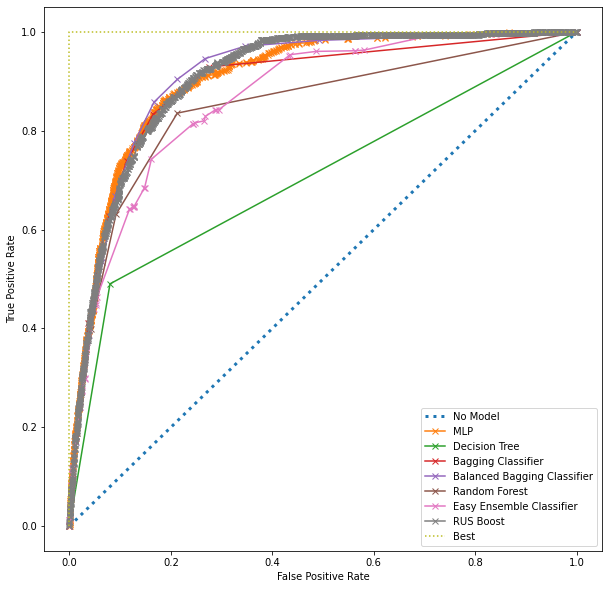

In [ ]:
# Calculate ROC Curves
nomodel_fpr, nomodel_tpr, _ = roc_curve(y_val, nomodel_probs)
mlp_fpr, mlp_tpr, _ = roc_curve(y_val, mlp_probs)
decisiontree_fpr, decisiontree_tpr, _ = roc_curve(y_val, decisiontree_probs)
bagging_fpr, bagging_tpr, _ = roc_curve(y_val, bagging_probs)
balanced_bagging_fpr, balanced_bagging_tpr, _ = roc_curve(y_val, balanced_bagging_probs)
randomforest_fpr, randomforest_tpr, _ = roc_curve(y_val, randomforest_probs)
balanced_randomforest_fpr, balanced_randomforest_tpr, _ = roc_curve(y_val, balanced_randomforest_probs)
eec_fpr, eec_tpr, _ = roc_curve(y_val, eec_probs)
rusboost_fpr, rusboost_tpr, _ = roc_curve(y_val, rusboost_probs)
xgboost_fpr, xgboost_tpr, _ = roc_curve(y_val, xgboost_probs)
best_fpr, best_tpr, _ = roc_curve(y_val, best_probs)

plt.figure(figsize=(10,10))
# plot the roc curve for the model
plt.plot(nomodel_fpr, nomodel_tpr, linestyle=':',linewidth=3, label='No Model')

plt.plot(mlp_fpr, mlp_tpr, marker='x', label='MLP')
plt.plot(decisiontree_fpr, decisiontree_tpr, marker='x', label='Decision Tree')
plt.plot(bagging_fpr, bagging_tpr, marker='x', label='Bagging Classifier')
plt.plot(balanced_bagging_fpr, balanced_bagging_tpr, marker='x', label='Balanced Bagging Classifier')
plt.plot(randomforest_fpr, randomforest_tpr, marker='x', label='Random Forest')
plt.plot(balanced_randomforest_fpr, balanced_randomforest_tpr, marker='x', label='Balanced Random Forest')
plt.plot(eec_fpr, eec_tpr, marker='x', label='Easy Ensemble Classifier')
plt.plot(rusboost_fpr, rusboost_tpr, marker='x', label='RUS Boost')
plt.plot(xgboost_fpr, xgboost_tpr, marker='x', label='XGBoost Classifier')
plt.plot(best_fpr, best_tpr, linestyle=':', label='Best')

# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Show the legend
plt.legend()

# Show the plot
plt.show()

# G. Predict

In [ ]:
df_test_pred = df_test_merge

In [ ]:
# Từ model tính predict sẽ ra 0 1
predict = best_rusboost.predict(df_test_pred) # df test merge
predict

array([0, 1, 1, ..., 0, 1, 0])

In [ ]:
predict = pd.DataFrame({'ID': df_test.index, 'subscribed': predict}) # raw df_test
predict.head()

,ID,subscribed
0,38441,0
1,40403,1
2,3709,1
3,37422,0
4,12527,0


In [ ]:
predict = predict.merge(df_test_pred,on='ID') # df test merge
predict.head(5)

,ID,subscribed,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,38441,0,32,118,15,20,6,-1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,40403,1,78,2787,1,372,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,3709,1,31,144,16,676,1,-1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,37422,0,57,3777,13,65,2,-1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,12527,0,45,-705,3,111,1,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


# H. New Policy on Trial

## H.1 List out

In [ ]:
predict[predict['subscribed'] == 1].shape

(3143, 53)

In [ ]:
new_policy = predict.copy(True)
new_policy = new_policy.drop(columns=['subscribed'])
new_policy = new_policy.drop(columns=['ID'])

## H.2 Implement that New Policy

In [ ]:
print('Duration unique values: ', df_test_pred['duration'].unique()) # df test merge

Duration unique values:  [  20  372  676 ... 1085 1745  881]


In [ ]:
new_policy

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,32,118,15,20,6,-1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,78,2787,1,372,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,31,144,16,676,1,-1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,57,3777,13,65,2,-1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,45,-705,3,111,1,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13559,39,45,28,148,4,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
13560,54,2281,20,158,1,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
13561,35,285,29,136,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
13562,29,464,9,208,2,91,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [ ]:
df_test_pred.head()

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
38441,32,118,15,20,6,-1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
40403,78,2787,1,372,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3709,31,144,16,676,1,-1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
37422,57,3777,13,65,2,-1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
12527,45,-705,3,111,1,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [ ]:
new_policy['duration'] = 200
result = best_decision_tree.predict(new_policy)
len(np.where(result==1)[0])

443

In [ ]:
new_policy['duration'] = 150
result = best_decision_tree.predict(new_policy)
len(np.where(result==1)[0])

0

In [ ]:
new_policy['duration'] = 800
result = best_decision_tree.predict(new_policy)
len(np.where(result==1)[0])

5445

## H.3 Result

443 customers will be targeted for the term deposit campaign instead of 0 with entropy = ... when changing the duration (most influential feature by ... Classifier) to 200 for example (as long as the cross entropy greater than ....). 

When changing the duration to more than 800, 5445 customers will be targeted.